# 2η Εργαστήριακή ΄Ασκηση Αναγνώριση Προτύπων
# Αναγνώριση Είδους και Εξαγωγή Συναισθήματος από Μουσική

Ονοματεπώνυμο: Άρης Μαρκογιαννάκης

ΑΜ: 03120085

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

os.listdir("../input/patreco3-multitask-affective-music/data/")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multitask-affective-music-lab-2022/patreco3-multitask-affective-music
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/test/6459.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/7429.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/test/39552.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/23678.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/test/39552.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/23678.fused.full.npy


['multitask_dataset_beat',
 'fma_genre_spectrograms',
 'fma_genre_spectrograms_beat',
 'multitask_dataset']

In [3]:
# clone the respective repo
# make sure you have the Internet option enabled under Session options
!git clone https://github.com/slp-ntua/patrec-labs.git

fatal: destination path 'patrec-labs' already exists and is not an empty directory.


In [4]:
# add path to system
import sys
sys.path.append('/kaggle/working/patrec-labs/lab3')

In [5]:
!ls

patrec-labs


In [6]:
# install requirements
!pip install -r patrec-labs/lab3/requirements.txt  #--force-reinstall

     |████████████████████████████████| 15.7 MB 5.3 MB/s            
     |████████████████████████████████| 750.6 MB 8.7 kB/s              
     |████████████████████████████████| 24.8 MB 52.7 MB/s            
     |████████████████████████████████| 287 kB 51.9 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0,

# **Βήμα 1: Εξοικείωση με φασματογραφήματα στην κλίμακα mel**


In [6]:
import random

# Φόρτωση αρχείου labels
labels_path = "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt"
labels_df = pd.read_csv(labels_path, sep=" ", header=None, names=["spec_file"])

def select_random_rows(df, label1, label2):
    
    # Filter rows ending with the desired labels
    df1 = df[df['spec_file'].str.strip().str.endswith(label1, na=False)]
    df2 = df[df['spec_file'].str.strip().str.endswith(label2, na=False)]
    
    # Sample one random row from each filtered DataFrame
    row1 = df1.sample(n=1)
    row2 = df2.sample(n=1)

    # Concatenate the two rows into a single DataFrame
    random_rows = pd.concat([row1, row2], ignore_index=True)

    return random_rows

# Επιλογή δύο τυχαίων γραμμών, μία με soundtrack και μία με Classical
random_rows = select_random_rows(labels_df, "Soundtrack", "Classical")

print(random_rows)

                             spec_file
0  36925.fused.full.npy.gz\tSoundtrack
1   47770.fused.full.npy.gz\tClassical


In [7]:
soundtrack_filename, soundtrack_label = random_rows.iloc[0]['spec_file'].split('\t')
classical_filename, classical_label   = random_rows.iloc[1]['spec_file'].split('\t')

soundtrack_filename = soundtrack_filename[:-3]
classical_filename  = classical_filename[:-3]

spec_soundtrack = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/{soundtrack_filename}')
spec_classical  = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/{classical_filename}')

print(f"spec_soundtrack: {spec_soundtrack}")
print(f"spec_classical:  {spec_classical}")

spec_soundtrack: [[-7.71287506e+01 -4.54104512e+01 -3.67907885e+01 ... -4.71198083e+01
  -4.04324477e+01 -2.52896124e+01]
 [-7.35504342e+01 -4.23284645e+01 -3.00613727e+01 ... -1.76123608e+01
  -1.84103311e+01 -1.58223201e+01]
 [-7.74528828e+01 -4.72961945e+01 -3.40499492e+01 ... -9.65305118e+00
  -1.03228352e+01 -1.00671729e+01]
 ...
 [ 6.28581533e-01  6.45332284e-01  4.87895282e-01 ...  5.01226856e-02
   2.02063478e-01  5.59201944e-01]
 [ 9.30386122e-01  6.07005573e-01  2.95255017e-01 ...  9.46218044e-02
   2.54124664e-01  4.70342782e-01]
 [ 5.82489655e-01  4.71717431e-01  2.71162992e-01 ...  2.82360111e-01
   4.10452475e-01  5.30831123e-01]]
spec_classical:  [[-67.0440642  -56.1508834  -51.36915704 ... -60.03375754 -61.54987631
  -40.31478313]
 [-61.00779201 -53.52183447 -47.97260598 ... -49.39781054 -48.0925403
  -40.79889721]
 [-60.96802799 -46.0406801  -41.60850929 ... -45.04981572 -47.7197821
  -38.78192168]
 ...
 [  0.44883404   0.4587158    0.20190235 ...   0.14393322   0.1373

In [8]:
spec_soundtrack = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/20375.fused.full.npy')
spec_classical  = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/28122.fused.full.npy')

In [9]:
mel_soundtrack, chroma_soundtrack = spec_soundtrack[:128], spec_soundtrack[128:]
mel_classical,  chroma_classical  = spec_classical[:128],  spec_classical[128:]

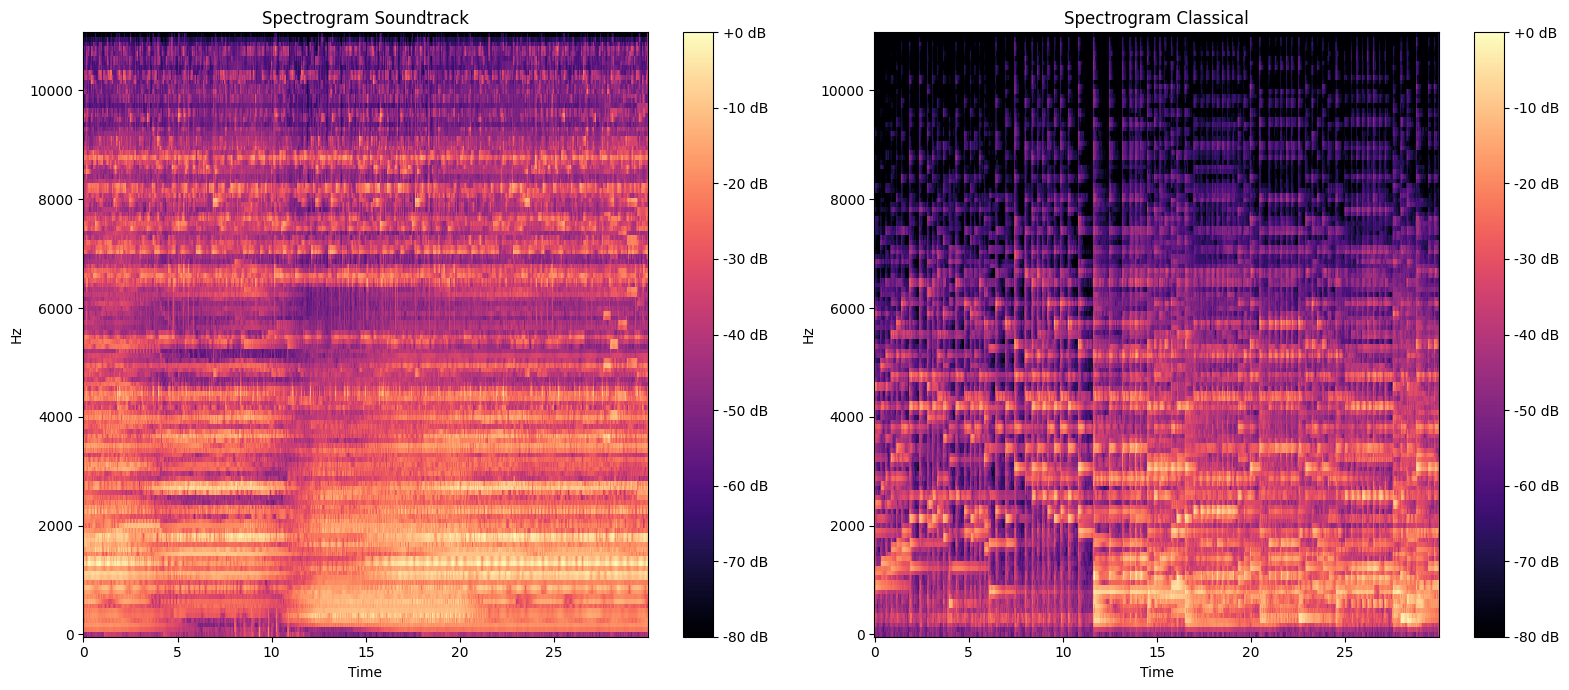

In [10]:
import librosa.display
import matplotlib.pyplot as plt

# Create a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Plot the spectrograms
axs[0].set_title('Spectrogram Soundtrack')
img = librosa.display.specshow(mel_soundtrack, x_axis='time', y_axis='linear', ax=axs[0])
fig.colorbar(img, ax=axs[0], format="%+2.f dB")

axs[1].set_title('Spectrogram Classical')
img = librosa.display.specshow(mel_classical, x_axis='time', y_axis='linear', ax=axs[1])
fig.colorbar(img, ax=axs[1], format="%+2.f dB")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('step1c.png', dpi=300)
plt.show()


# **Βήμα 2: Συγχρονισμός φασματογραφημάτων στο ρυθμό της μουσικής (beat-synced spectrograms)**

In [11]:
print(f"Soundtrack shape of spectrogram: {mel_soundtrack.shape}")
print(f"Classical  shape of spectrogram: {mel_classical.shape}")

Soundtrack shape of spectrogram: (128, 1291)
Classical  shape of spectrogram: (128, 1292)


In [12]:
spec_soundtrack_beat = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/20375.fused.full.npy')
spec_classical_beat  = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/28122.fused.full.npy')

In [13]:
#spec_soundtrack = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/{soundtrack_filename}')#
#spec_classical  = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/{classical_filename}')

mel_soundtrack_beat, chroma_soundtrack_beat = spec_soundtrack_beat[:128], spec_soundtrack_beat[128:]
mel_classical_beat,  chroma_classical_beat  = spec_classical_beat[:128],  spec_classical_beat[128:]

print(f"Soundtrack shape of spectrogram: {spec_soundtrack_beat.shape}")
print(f"Classical  shape of spectrogram: {mel_classical_beat.shape}")

print(f"spec_soundtrack: {spec_soundtrack}")
print(f"spec_classical:  {spec_classical}")

Soundtrack shape of spectrogram: (140, 55)
Classical  shape of spectrogram: (128, 92)
spec_soundtrack: [[-21.74166676 -27.91138528 -42.26311403 ... -42.87822161 -38.17873442
  -35.12081961]
 [-20.4809019  -21.42233274 -22.30302325 ... -21.86373018 -21.85415285
  -22.21019352]
 [-22.34221702 -19.39564444 -18.42228057 ... -17.85904898 -18.00307105
  -18.1593242 ]
 ...
 [  0.24038028   0.66509517   0.54050271 ...   0.52772239   0.51605341
    0.54621816]
 [  0.2973735    0.44648713   0.44021981 ...   0.26096719   0.23656878
    0.17807858]
 [  0.25865161   0.54237271   0.38353742 ...   0.24128058   0.18208547
    0.2594828 ]]
spec_classical:  [[-49.26773501 -51.63951159 -51.97558521 ... -44.0353717  -44.69523232
  -34.59546537]
 [-44.40437008 -43.16339337 -46.31681629 ... -42.61914946 -40.52239543
  -32.11787841]
 [-45.6339073  -36.92061338 -34.27242498 ... -34.80836491 -33.26465293
  -34.02382841]
 ...
 [  1.           0.3205655    0.31093706 ...   0.40648593   0.34597723
    0.36969412]

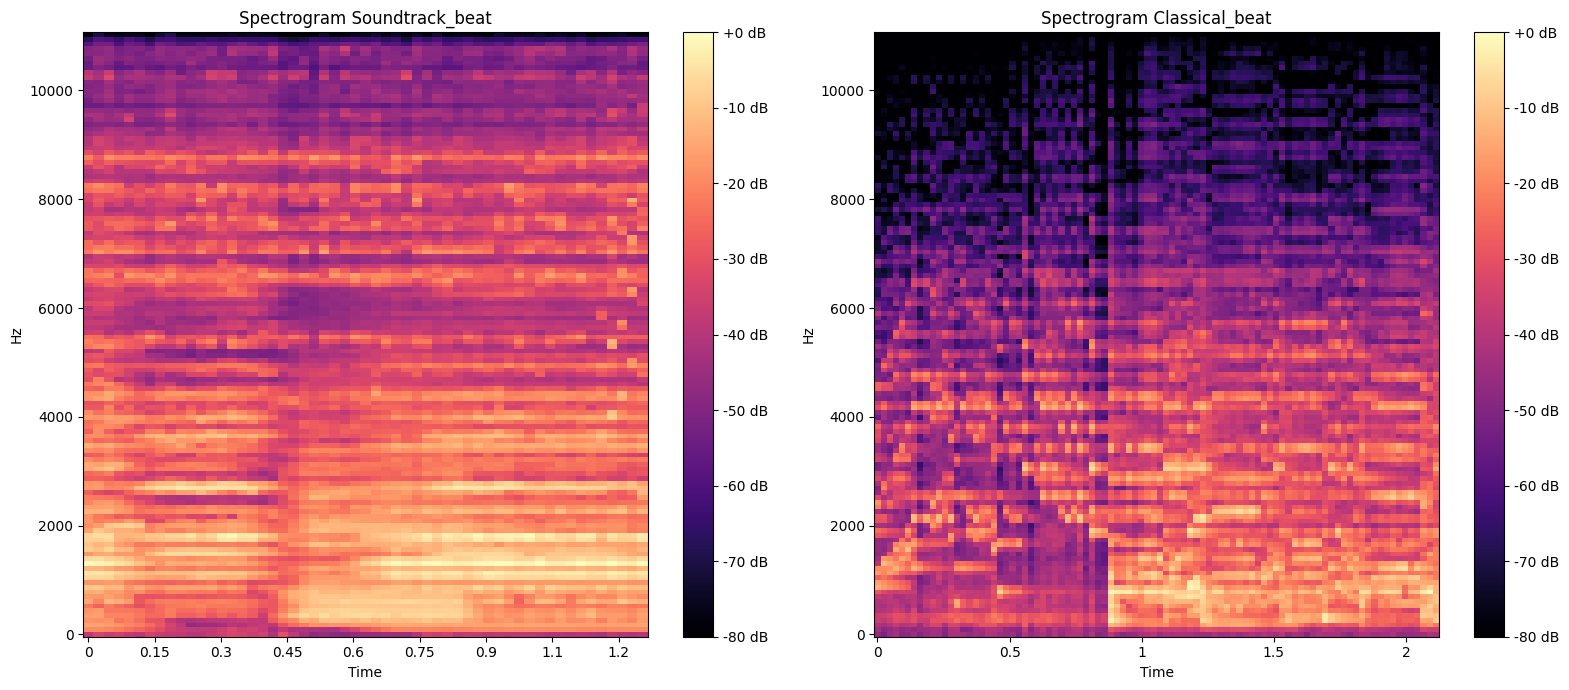

In [14]:
import librosa.display
import matplotlib.pyplot as plt
# Create a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Plot the spectrograms
axs[0].set_title('Spectrogram Soundtrack_beat')
img = librosa.display.specshow(mel_soundtrack_beat, x_axis='time', y_axis='linear', ax=axs[0])
fig.colorbar(img, ax=axs[0], format="%+2.f dB")

axs[1].set_title('Spectrogram Classical_beat')
img = librosa.display.specshow(mel_classical_beat, x_axis='time', y_axis='linear', ax=axs[1])
fig.colorbar(img, ax=axs[1], format="%+2.f dB")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('step2b_plot.png')
plt.show()

# **Βήμα 3: Εξοικείωση με χρωμογραφήματα**

In [15]:
spec_soundtrack = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/20375.fused.full.npy')
spec_classical  = np.load(f'/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/28122.fused.full.npy')

In [16]:
mel_soundtrack, chroma_soundtrack = spec_soundtrack[:128], spec_soundtrack[128:]
mel_classical,  chroma_classical  = spec_classical[:128],  spec_classical[128:]

print(f"Soundtrack shape of chromogram: {chroma_soundtrack.shape}")
print(f"Classical  shape of chromogram: {chroma_classical.shape}")

Soundtrack shape of chromogram: (12, 1291)
Classical  shape of chromogram: (12, 1292)


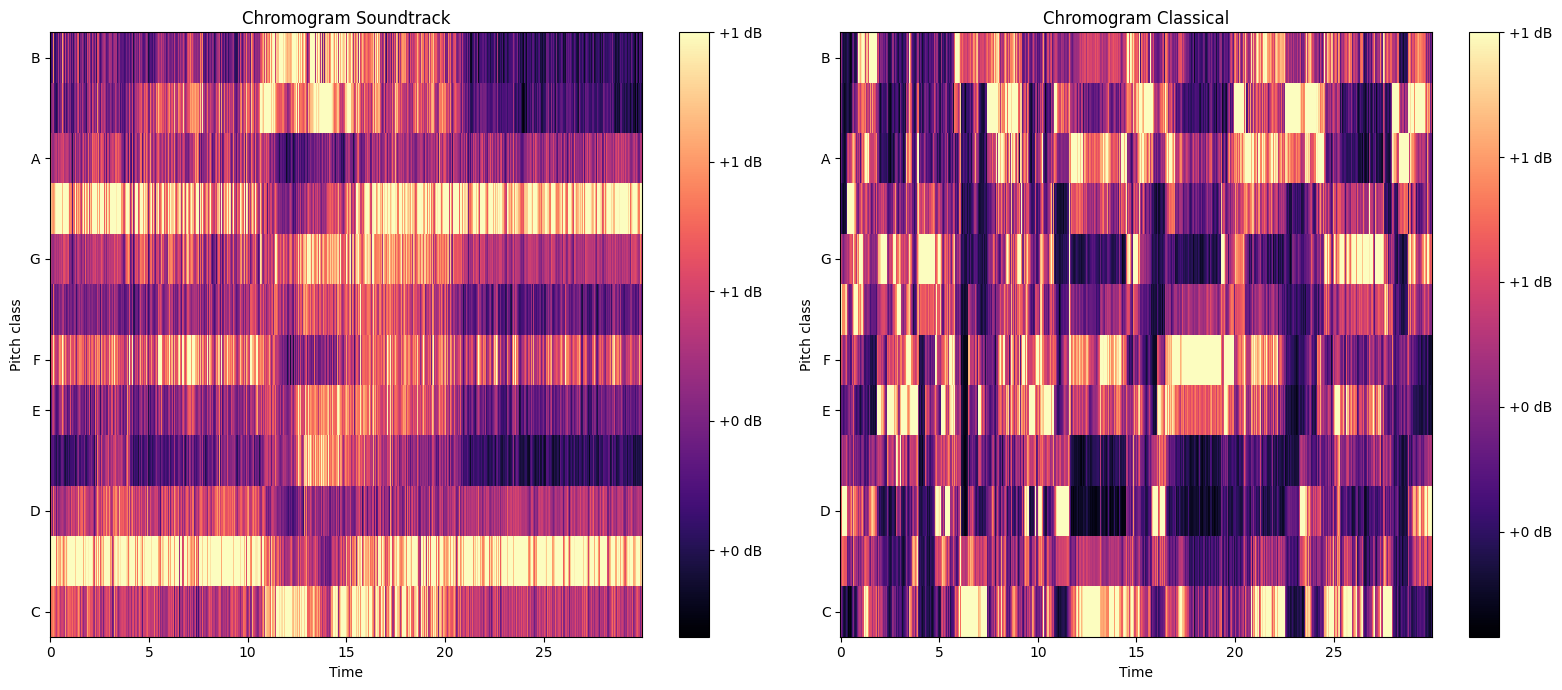

In [17]:
import librosa.display
import matplotlib.pyplot as plt

# Create a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Plot the spectrograms
axs[0].set_title('Chromogram Soundtrack')
img = librosa.display.specshow(chroma_soundtrack,  y_axis='chroma', x_axis='time',  ax=axs[0])
fig.colorbar(img, ax=axs[0], format="%+2.f dB")

axs[1].set_title('Chromogram Classical')
img = librosa.display.specshow(chroma_classical,  y_axis='chroma', x_axis='time',  ax=axs[1])
fig.colorbar(img, ax=axs[1], format="%+2.f dB")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('step3plot.png', dpi=300)
plt.show()


In [18]:
print(f"Soundtrack_beat shape of chromogram: {chroma_soundtrack_beat.shape}")
print(f"Classical_beat  shape of chromogram: {chroma_classical_beat.shape}")

Soundtrack_beat shape of chromogram: (12, 55)
Classical_beat  shape of chromogram: (12, 92)


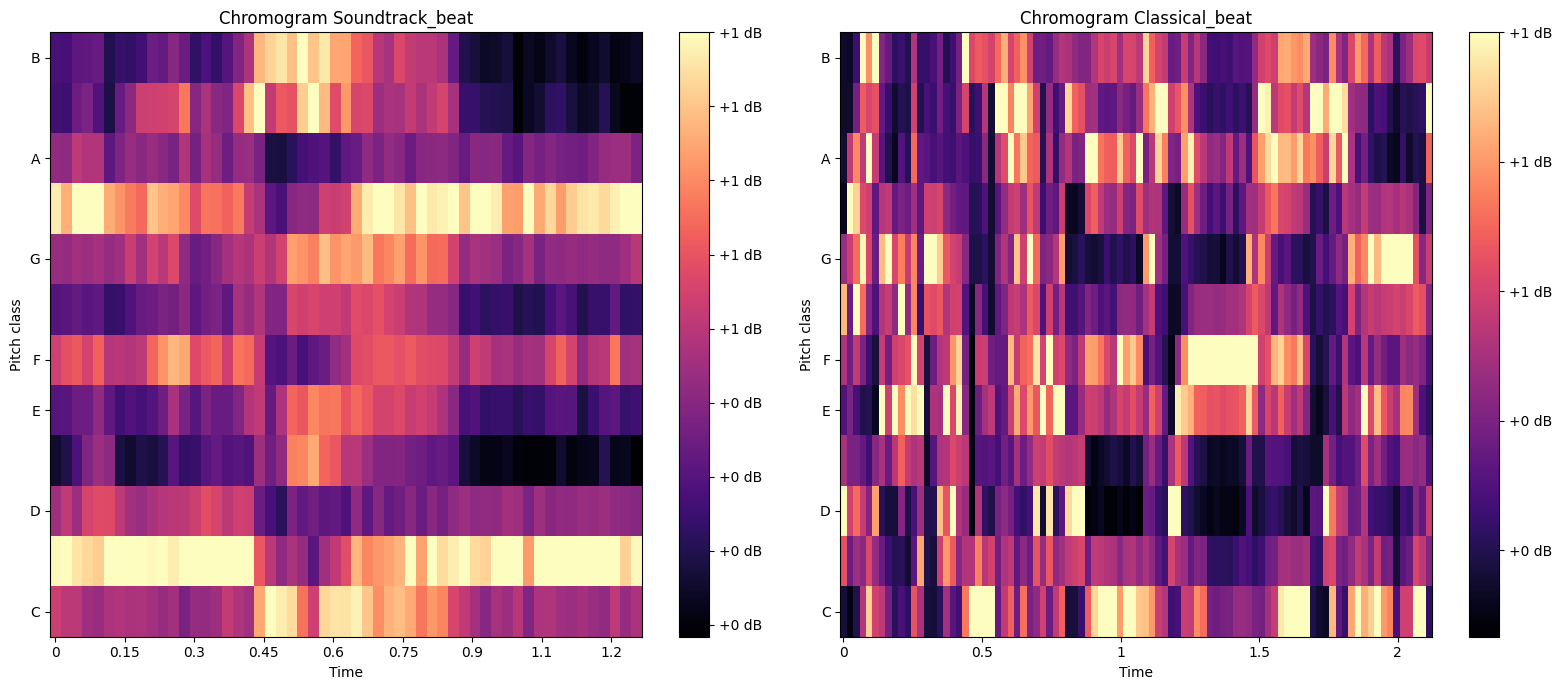

In [19]:
import librosa.display
import matplotlib.pyplot as plt
# Create a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Plot the spectrograms
axs[0].set_title('Chromogram Soundtrack_beat')
img = librosa.display.specshow(chroma_soundtrack_beat,  y_axis='chroma', x_axis='time', ax=axs[0])
fig.colorbar(img, ax=axs[0], format="%+2.f dB")

axs[1].set_title('Chromogram Classical_beat')
img = librosa.display.specshow(chroma_classical_beat,  y_axis='chroma', x_axis='time',  ax=axs[1])
fig.colorbar(img, ax=axs[1], format="%+2.f dB")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('step3plotbeat.png')
plt.show()

# **Βήμα 4: Φόρτωση και ανάλυση δεδομένων**

In [4]:
# dataset.py

import copy
import os

import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

# HINT: Use this class mapping to merge similar classes and ignore classes that do not work very well
CLASS_MAPPING = {
    "Rock": "Rock",
    "Psych-Rock": "Rock",
    "Indie-Rock": None,
    "Post-Rock": "Rock",
    "Psych-Folk": "Folk",
    "Folk": "Folk",
    "Metal": "Metal",
    "Punk": "Metal",
    "Post-Punk": None,
    "Trip-Hop": "Trip-Hop",
    "Pop": "Pop",
    "Electronic": "Electronic",
    "Hip-Hop": "Hip-Hop",
    "Classical": "Classical",
    "Blues": "Blues",
    "Chiptune": "Electronic",
    "Jazz": "Jazz",
    "Soundtrack": None,
    "International": None,
    "Old-Time": None,
}


def torch_train_val_split(
    dataset, batch_train, batch_eval, val_size=0.2, shuffle=True, seed=420
):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_train, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_eval, sampler=val_sampler)
    return train_loader, val_loader


def read_spectrogram(spectrogram_file, feat_type):
    spectrogram = np.load(spectrogram_file)
    # spectrograms contains a fused mel spectrogram and chromagram    
    if feat_type=='mel':
        return spectrogram[:128, :].T
    elif feat_type=='chroma':
        return spectrogram[128:, :].T

    return spectrogram.T


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[: self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1


class SpectrogramDataset(Dataset):
    def __init__(
        self, path, class_mapping=None, train=True, feat_type='mel', max_length=-1, regression=None
    ):
        t = "train" if train else "test"
        p = os.path.join(path, t)
        self.regression = regression

        self.full_path = p
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spectrogram(os.path.join(p, f), feat_type) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            if not regression:
                self.labels = np.array(
                    self.label_transformer.fit_transform(labels)
                ).astype("int64")
            else:
                self.labels = np.array(labels).astype("float64")

    def get_files_labels(self, txt, class_mapping):
        with open(txt, "r") as fd:
            lines = [l.rstrip().split("\t") for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            if self.regression:
                l = l[0].split(",")
                files.append(l[0] + ".fused.full.npy")
                labels.append(l[self.regression])
                continue
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            fname = l[0]
            if fname.endswith(".gz"):
                fname = ".".join(fname.split(".")[:-1])
            
            # necessary fixes for the custom dataset used in the lab
            if 'fma_genre_spectrograms_beat' in self.full_path.split('/'):
                fname = fname.replace('beatsync.fused', 'fused.full')            
            if 'test' in self.full_path.split('/'):
                fname = fname.replace('full.fused', 'fused.full')
            
            files.append(fname)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        length = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], length

    def __len__(self):
        return len(self.labels)



In [21]:
dataset = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=True
)

print(dataset[10])
print(f"Input: {dataset[10][0].shape}")
print(f"Label: {dataset[10][1]}")
print(f"Original length: {dataset[10][2]}")

(array([[-52.26681477, -52.71678237, -52.83256794, ..., -80.        ,
        -80.        , -80.        ],
       [-45.12944043, -49.20641678, -51.77639735, ..., -80.        ,
        -80.        , -80.        ],
       [-44.2435711 , -42.88079978, -46.60278858, ..., -80.        ,
        -80.        , -80.        ],
       ...,
       [-38.86648128, -42.70998466, -46.1181    , ..., -58.58672545,
        -61.70087117, -63.41518897],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]]), 0, 1291)
Input: (1293, 128)
Label: 0
Original length: 1291


/tmp/ipykernel_23/3799985851.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(original_counts.keys(), rotation=45, ha='right')
/tmp/ipykernel_23/3799985851.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(merged_counts.keys(), rotation=45, ha='right')


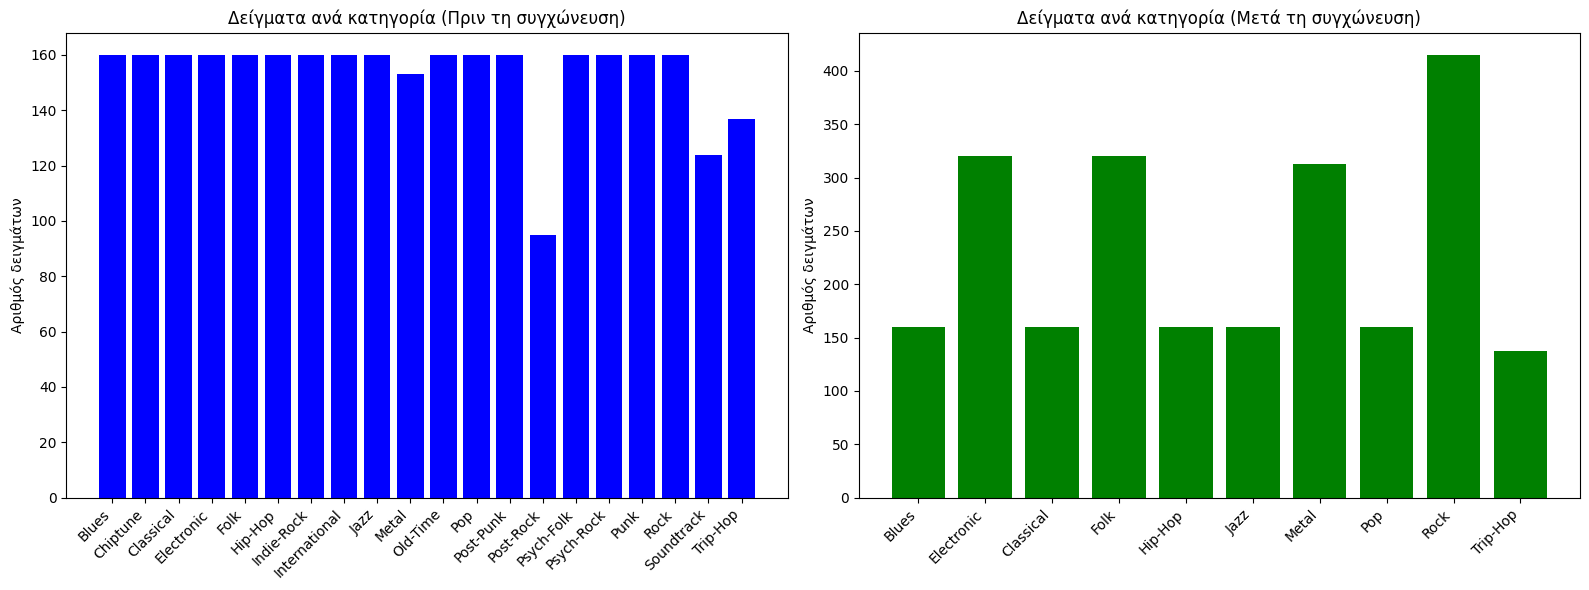

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

# Διαβάζουμε το αρχικό dataset
with open("../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt", "r") as fd:
    lines = [line.rstrip().split("\t")[1] for line in fd.readlines()[1:]]
original_labels = [line for line in lines if line in CLASS_MAPPING]  # Κρατάμε μόνο τις σχετικές κλάσεις

# Δημιουργούμε ετικέτες μετά τη συγχώνευση
merged_labels = [CLASS_MAPPING[label] for label in original_labels if CLASS_MAPPING[label] is not None]

# Υπολογίζουμε τις συχνότητες
original_counts = Counter(original_labels)
merged_counts = Counter(merged_labels)

# Σχεδιάζουμε τα ιστογράμματα
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(original_counts.keys(), original_counts.values(), color='blue')
axes[0].set_title("Δείγματα ανά κατηγορία (Πριν τη συγχώνευση)")
axes[0].set_ylabel("Αριθμός δειγμάτων")
axes[0].set_xticklabels(original_counts.keys(), rotation=45, ha='right')

axes[1].bar(merged_counts.keys(), merged_counts.values(), color='green')
axes[1].set_title("Δείγματα ανά κατηγορία (Μετά τη συγχώνευση)")
axes[1].set_ylabel("Αριθμός δειγμάτων")
axes[1].set_xticklabels(merged_counts.keys(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('step4.png')
plt.show()


# **Βήμα 5: Αναγνώριση μουσικού είδους με LSTM.**

In [115]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from itertools import product


class EarlyStopping(object):
    def __init__(self, patience, mode="min", base=None):
        self.best = base
        self.patience = patience
        self.patience_left = patience
        self.mode = mode

    def stop(self, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Decrease patience if the metric has not improved
        # Stop when patience reaches zero
        if not self.has_improved(value):
            self.patience_left -= 1
            if self.patience_left == 0:
                return True
        else:
            self.patience_left = self.patience
        return False

    def has_improved(self, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Check if the metric has improved
        if self.best is None:
            self.best = value
            return True
        if self.mode == "min" and value <= self.best:
            self.best = value
            return True
        elif self.mode == "max" and value >= self.best:
            self.best = value
            return True
        return False

class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
        feats: Python list of numpy arrays that contain the sequence features.
               Each element of this list is a numpy array of shape seq_length x feature_dimension
        labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        # TODO: YOUR CODE HERE
        self.lengths = [len(i) for i in feats]

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype("int64")

        

    def zero_pad_and_stack(self, x: np.ndarray) -> np.ndarray:
        """
        This function performs zero padding on a list of features and forms them into a numpy 3D array
        returns
            padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        
        # TODO: YOUR CODE HERE
        # --------------- Insert your code here ---------------- #

        max_seq_len = max(len(seq) for seq in x)
        feature_dim = x[0].shape[1] if x else 0
        padded = np.zeros((len(x), max_seq_len, feature_dim))
        for i, seq in enumerate(x):
            padded[i, :len(seq)] = seq
        return padded

    def __getitem__(self, item):
        feats = self.feats[item].astype(np.float32)  # Ensure features are float32
        labels = self.labels[item]
        lengths = self.lengths[item]
        return feats, labels, lengths

    def __len__(self):
        return len(self.feats)


class BasicLSTM(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size,
        output_dim,
        num_layers,
        bidirectional=False,
        dropout=0.0,
    ):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # TODO: YOUR CODE HERE
        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers

        self.lstm = nn.LSTM(
            input_dim,
            rnn_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout,
        )
        
        # Dropout Layer
        self.dropout = nn.Dropout(dropout)
        
        # Output Layer
        self.fc = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """
        x : 3D numpy array of dimension N x L x D
            N: batch index
            L: sequence index
            D: feature index

        lengths: N x 1
        """

        # TODO: YOUR CODE HERE
        # --------------- Insert your code here ---------------- #

        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network
        # Forward pass through the LSTM layer
        x = x.to(torch.float32)

        lstm_out, _ = self.lstm(x)  # Shape: (batch_size, sequence_length, hidden_size * num_directions)
        
        # Obtain the last relevant output for each sequence using `last_timestep`
        last_outputs = self.last_timestep(lstm_out, lengths, self.bidirectional)
        
        # Apply dropout to the last relevant outputs
        last_outputs = self.dropout(last_outputs)
        
        # Pass through the final fully connected layer
        return self.fc(last_outputs)

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
        Returns the last output of the LSTM taking into account the zero padding
        """
        # TODO: READ THIS CODE AND UNDERSTAND WHAT IT DOES
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        # TODO: READ THIS CODE AND UNDERSTAND WHAT IT DOES
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # TODO: READ THIS CODE AND UNDERSTAND WHAT IT DOES
        # Index of the last output for each sequence.
        idx = (
            (lengths - 1)
            .view(-1, 1)
            .expand(outputs.size(0), outputs.size(2))
            .unsqueeze(1)
        )
        return outputs.gather(1, idx).squeeze()
    

import torch.nn.utils.rnn as rnn_utils

class PackedLSTM(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size,
        output_dim,
        num_layers,
        bidirectional=False,
        dropout=0.0,
    ):
        super(PackedLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # Initialize the LSTM, Dropout, Output layers
        self.lstm = nn.LSTM(
            input_dim,
            rnn_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """
        x : 3D numpy array of dimension N x L x D
            N: batch index
            L: sequence index
            D: feature index

        lengths: N x 1
        """
        # Sort the batch by sequence length in descending order
        lengths, perm_idx = lengths.sort(0, descending=True)
        x = x[perm_idx]

        # Pack the padded batch of sequences
        packed_input = rnn_utils.pack_padded_sequence(x, lengths.cpu(), batch_first=True)

        # Forward pass through LSTM
        packed_output, (h_n, c_n) = self.lstm(packed_input)

        # Unpack the sequences
        lstm_out, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)

        # Restore the original order
        _, unperm_idx = perm_idx.sort(0)
        lstm_out = lstm_out[unperm_idx]

        # Obtain the last relevant output for each sequence
        last_outputs = self.last_timestep(lstm_out, lengths, self.bidirectional)

        # Apply dropout and pass through the final fully connected layer
        last_outputs = self.dropout(last_outputs)
        return self.fc(last_outputs)

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
        Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            return torch.cat((last_forward, last_backward), dim=-1)
        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        idx = (
            (lengths - 1)
            .view(-1, 1)
            .expand(outputs.size(0), outputs.size(2))
            .unsqueeze(1)
        )
        return outputs.gather(1, idx).squeeze()



In [116]:
def compute_loss(predictions, targets):
    criterion = nn.CrossEntropyLoss()  # Or another loss function based on your task
    return criterion(predictions, targets)


def save_checkpoint(model, optimizer, epoch, file_path="checkpoint.pth"):
    """Save model checkpoint.
    Args:
        model (nn.Module): Model to save.
        optimizer (torch.optim.Optimizer): Optimizer to save.
        epoch (int): Current epoch number.
        file_path (str): Path to save the checkpoint.
    """
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at epoch {epoch} to {file_path}")


def training_loop(model, train_dataloader, optimizer, device="cuda"):
    """Training loop for a single epoch.
    Args:
        model (nn.Module): Model to train.
        train_dataloader (DataLoader): Training data loader.
        optimizer (torch.optim.Optimizer): Optimizer.
        device (str): Device to train on ("cuda" or "cpu").
    Returns:
        float: Training loss for the epoch.
    """
    torch.set_default_tensor_type(torch.FloatTensor)
    model.train()
    total_loss = 0
    #inputs = torch.tensor(data, dtype=torch.float32)
    for batch in train_dataloader:
        inputs, targets, lengths = batch
        inputs, targets, lengths = (
                inputs.float().to(device),
                targets.to(device),
                lengths.to(device),
            )

        optimizer.zero_grad()
        #loss, _ = model(inputs, targets, lengths)
        #outputs = model(inputs, lengths)
        #loss = compute_loss(outputs, targets)

        outputs = model(inputs, lengths)
        #print(outputs)
        loss = compute_loss(outputs, targets)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_dataloader)


def validation_loop(model, val_dataloader, device="cpu"):
    """Validation loop for a single epoch.
    Args:
        model (nn.Module): Model to validate.
        val_dataloader (DataLoader): Validation data loader.
        device (str): Device to validate on ("cuda" or "cpu").
    Returns:
        float: Validation loss for the epoch.
        float: Validation accuracy for the epoch.
    """
    torch.set_default_tensor_type(torch.FloatTensor)
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, targets, lengths = batch
            inputs, targets, lengths = (
                inputs.float().to(device),
                targets.to(device),
                lengths.to(device),
            )

            #loss, outputs = model(inputs,targets, lengths)
            #loss = compute_loss(outputs, targets)
            
            outputs = model(inputs, lengths)
            #print(outputs)
            loss = compute_loss(outputs, targets)
            
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get the predicted class index
            correct += (predicted == targets).sum().item()  # Count correct predictions
            total += targets.size(0)  # Total number of targets

    avg_loss = total_loss / len(val_dataloader)
    accuracy = correct / total if total > 0 else 0

    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


def overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, device="cuda"):
    """Overfit the model on a small subset of batches.
    Args:
        model (nn.Module): Model to train.
        train_dataloader (DataLoader): Training data loader.
        optimizer (torch.optim.Optimizer): Optimizer.
        device (str): Device to train on ("cuda" or "
        ").
    """
    torch.set_default_tensor_type(torch.FloatTensor)
    model.train()
    small_subset = []
    for i, batch in enumerate(train_dataloader):
        small_subset.append(batch)
        if len(small_subset) >= 3:  # Take only 3 batches
            break
    #inputs = torch.tensor(small_subset, dtype=torch.float32)
    #print("before loops overfit\n")
    for epoch in range(600):  # Train for many epochs to observe overfitting
        total_loss = 0
        for batch in small_subset:
            inputs, targets, lengths = batch
            inputs, targets, lengths = (
                inputs.float().to(device),
                targets.to(device),
                lengths.to(device),
            )

            optimizer.zero_grad()
            #loss, outputs= model(inputs, targets, lengths)
            outputs = model(inputs, lengths)
            #print(outputs)
            loss = compute_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if((epoch + 1) % 100 == 0):
            print(f"Epoch {epoch+1}, Loss: {total_loss / len(small_subset)}")
        if total_loss < 0.3:  # Stop if sufficiently overfit
            break


def train(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    epochs,
    device="cuda",
    overfit_batch=False,
    file_path="somepath"
):
    """Main training function.
    Args:
        model (nn.Module): Model to train.
        train_dataloader (DataLoader): Training data loader.
        val_dataloader (DataLoader): Validation data loader.
        optimizer (torch.optim.Optimizer): Optimizer.
        epochs (int): Number of epochs to train.
        device (str): Device to train on ("cuda" or "cpu").
        overfit_batch (bool): Whether to overfit a small subset of batches.
    """
    model.to(device)
    if overfit_batch:
        overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, device)
        return

    best_val_accuracy = 0 
    early_stop_count = 0
    patience = 5  # Early stopping patience

    for epoch in range(epochs):
        # Training step
        train_loss = training_loop(model, train_dataloader, optimizer, device)

        # Validation step
        val_loss, val_accuracy = validation_loop(model, val_dataloader, device)

        # Print training and validation metrics
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_checkpoint(model, optimizer, epoch, file_path)
            early_stop_count = 0
        else:
            early_stop_count += 1

        # Early stopping
        if early_stop_count >= patience:
            print("Early stopping triggered.")
            break

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
MAX_LENGTH = 150

Using device: cuda


**γ) εκπαιδεύστε ένα LSTM [15] δίκτυο, το οποίο θα δέχεται ως είσοδο τα φασματογραφήματα του
συνόλου εκπαίδευσης (train set) και θα προβλέπει τις διαφορετικές κλάσεις (μουσικά είδη) του συνόλου
δεδομένων (dataset).**

In [118]:
device = "cuda"


dataset_c = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=True, max_length = MAX_LENGTH
)
print(f"dataset length: {len(dataset_c)}")

print("dataset created\n")

train_dataloader_c, val_dataloader_c = torch_train_val_split(
    dataset=dataset_c, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True, seed=420
)

for inputs, targets, lengths in train_dataloader_c:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_c:
    inputs = inputs.float()
    targets = targets.float()  

print("dataset splited\n")

dataset length: 2305
dataset created

dataset splited



In [128]:
model_c = BasicLSTM(input_dim=128, rnn_size=64, output_dim=10, num_layers=2, bidirectional=True, dropout=0.3)
model_c.criterion = nn.CrossEntropyLoss()
torch.set_default_dtype(torch.float32)

optimizer = torch.optim.Adam(model_c.parameters(), lr=1e-3)



# Run overfit debugging step

train(
    model=model_c,
    train_dataloader=train_dataloader_c,
    val_dataloader=val_dataloader_c,
    optimizer=torch.optim.Adam(model_c.parameters(), lr=0.0001),
    epochs=500,  # Many epochs for overfitting
    device=device,
    overfit_batch=True  # Activate overfit mode
)




Epoch 100, Loss: 1.3234968582789104
Epoch 200, Loss: 1.5026862223943074
Epoch 300, Loss: 0.7602333227793375
Epoch 400, Loss: 0.5284750958283743
Epoch 500, Loss: 0.6955127716064453
Epoch 600, Loss: 0.5894343852996826


In [129]:

train(
    model=model_c,
    train_dataloader=train_dataloader_c,
    val_dataloader=val_dataloader_c,
    optimizer=torch.optim.Adam(model_c.parameters(), lr=0.0001),
    epochs=50,  # Fewer epochs for general training
    device=device,
    overfit_batch=False,  # Train on the full dataset
    file_path="model_c.pth"
)

Validation Loss: 2.0815, Accuracy: 0.2755
Epoch 1/50
Training Loss: 2.2792, Validation Loss: 2.0815, Validation Accuracy: 0.2755
Checkpoint saved at epoch 0 to model_c.pth
Validation Loss: 2.0091, Accuracy: 0.2711
Epoch 2/50
Training Loss: 2.0416, Validation Loss: 2.0091, Validation Accuracy: 0.2711
Validation Loss: 1.9683, Accuracy: 0.3015
Epoch 3/50
Training Loss: 1.9901, Validation Loss: 1.9683, Validation Accuracy: 0.3015
Checkpoint saved at epoch 2 to model_c.pth
Validation Loss: 1.9358, Accuracy: 0.2842
Epoch 4/50
Training Loss: 1.9328, Validation Loss: 1.9358, Validation Accuracy: 0.2842
Validation Loss: 1.9187, Accuracy: 0.3210
Epoch 5/50
Training Loss: 1.9127, Validation Loss: 1.9187, Validation Accuracy: 0.3210
Checkpoint saved at epoch 4 to model_c.pth
Validation Loss: 1.9134, Accuracy: 0.3015
Epoch 6/50
Training Loss: 1.8855, Validation Loss: 1.9134, Validation Accuracy: 0.3015
Validation Loss: 1.8783, Accuracy: 0.3015
Epoch 7/50
Training Loss: 1.8767, Validation Loss: 1.87

**δ) εκπαιδεύστε ένα LSTM δίκτυο, το οποίο θα δέχεται ως είσοδο τα beat-synced spectrograms (train set)
και θα προβλέπει τις διαφορετικές κλάσεις (μουσικά είδη) του συνόλου δεδομένων**

In [121]:
device = "cuda"


dataset_d = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat", class_mapping=CLASS_MAPPING, train=True, max_length = MAX_LENGTH
)
print(f"dataset length: {len(dataset_c)}")

print("dataset created\n")

train_dataloader_d, val_dataloader_d = torch_train_val_split(
    dataset=dataset_c, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True, seed=420
)

for inputs, targets, lengths in train_dataloader_d:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_d:
    inputs = inputs.float()
    targets = targets.float()  

print("dataset splited\n")

dataset length: 2305
dataset created

dataset splited



In [168]:
model_d = BasicLSTM(input_dim=128, rnn_size=64, output_dim=10, num_layers=2, bidirectional=True, dropout=0.3)
model_d.criterion = nn.CrossEntropyLoss()
torch.set_default_dtype(torch.float32)

optimizer = torch.optim.Adam(model_d.parameters(), lr=1e-3)



# Run overfit debugging step

train(
    model=model_d,
    train_dataloader=train_dataloader_d,
    val_dataloader=val_dataloader_d,
    optimizer=torch.optim.Adam(model_d.parameters(), lr=0.0001),
    epochs=500,  # Many epochs for overfitting
    device=device,
    overfit_batch=True  # Activate overfit mode
)




Epoch 100, Loss: 1.2304850419362385
Epoch 200, Loss: 1.096849004427592
Epoch 300, Loss: 0.5477109352747599
Epoch 400, Loss: 0.2947903374830882
Epoch 500, Loss: 0.49412046869595844
Epoch 600, Loss: 0.20031489431858063


In [170]:

train(
    model=model_d,
    train_dataloader=train_dataloader_d,
    val_dataloader=val_dataloader_d,
    optimizer=torch.optim.Adam(model_d.parameters(), lr=0.0001),
    epochs=50,  # Fewer epochs for general training
    device=device,
    overfit_batch=False,  # Train on the full dataset,
    file_path="model_d.pth"
)

Validation Loss: 2.0371, Accuracy: 0.2711
Epoch 1/50
Training Loss: 2.0719, Validation Loss: 2.0371, Validation Accuracy: 0.2711
Checkpoint saved at epoch 0 to model_d.pth
Validation Loss: 1.9990, Accuracy: 0.2842
Epoch 2/50
Training Loss: 2.0029, Validation Loss: 1.9990, Validation Accuracy: 0.2842
Checkpoint saved at epoch 1 to model_d.pth
Validation Loss: 1.9681, Accuracy: 0.2820
Epoch 3/50
Training Loss: 1.9806, Validation Loss: 1.9681, Validation Accuracy: 0.2820
Validation Loss: 1.9860, Accuracy: 0.2733
Epoch 4/50
Training Loss: 1.9602, Validation Loss: 1.9860, Validation Accuracy: 0.2733
Validation Loss: 1.9446, Accuracy: 0.3059
Epoch 5/50
Training Loss: 1.9397, Validation Loss: 1.9446, Validation Accuracy: 0.3059
Checkpoint saved at epoch 4 to model_d.pth
Validation Loss: 1.9400, Accuracy: 0.2863
Epoch 6/50
Training Loss: 1.9061, Validation Loss: 1.9400, Validation Accuracy: 0.2863
Validation Loss: 1.9375, Accuracy: 0.3059
Epoch 7/50
Training Loss: 1.9031, Validation Loss: 1.93

**ε) εκπαιδεύστε ένα LSTM δίκτυο, το οποίο θα δέχεται ως είσοδο τα χρωμογραφήματα (train set) και θα
προβλέπει τις διαφορετικές κλάσεις (μουσικά είδη) του συνόλου δεδομένων.**

In [133]:
device = "cuda"


dataset_e = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=True, feat_type = "chroma", max_length = MAX_LENGTH 
)
print(f"dataset length: {len(dataset_c)}")

print("dataset created\n")

train_dataloader_e, val_dataloader_e = torch_train_val_split(
    dataset=dataset_e, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True, seed=420
)

for inputs, targets, lengths in train_dataloader_e:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_e:
    inputs = inputs.float()
    targets = targets.float()  

print("dataset splited\n")

dataset length: 2305
dataset created

dataset splited



In [137]:
model_e = BasicLSTM(input_dim=12, rnn_size=64, output_dim=10, num_layers=2, bidirectional=True, dropout=0.3)
model_e.criterion = nn.CrossEntropyLoss()
torch.set_default_dtype(torch.float32)

optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-4)



# Run overfit debugging step

train(
    model=model_e,
    train_dataloader=train_dataloader_e,
    val_dataloader=val_dataloader_e,
    optimizer=torch.optim.Adam(model_e.parameters(), lr=0.0001),
    epochs=500,  # Many epochs for overfitting
    device=device,
    overfit_batch=True, # Activate overfit mode
)




Epoch 100, Loss: 2.136044502258301
Epoch 200, Loss: 1.6172809600830078
Epoch 300, Loss: 1.3042244116465251
Epoch 400, Loss: 0.9528949856758118
Epoch 500, Loss: 0.7985605994860331
Epoch 600, Loss: 0.6271546681722006


In [138]:

train(
    model=model_e,
    train_dataloader=train_dataloader_e,
    val_dataloader=val_dataloader_e,
    optimizer=torch.optim.Adam(model_e.parameters(), lr=0.0001),
    epochs=50,  # Fewer epochs for general training
    device=device,
    overfit_batch=False,  # Train on the full dataset
    file_path="model_e.pth"
)

Validation Loss: 2.5830, Accuracy: 0.1432
Epoch 1/50
Training Loss: 2.9752, Validation Loss: 2.5830, Validation Accuracy: 0.1432
Checkpoint saved at epoch 0 to model_e.pth
Validation Loss: 2.4068, Accuracy: 0.1562
Epoch 2/50
Training Loss: 2.5808, Validation Loss: 2.4068, Validation Accuracy: 0.1562
Checkpoint saved at epoch 1 to model_e.pth
Validation Loss: 2.3246, Accuracy: 0.1540
Epoch 3/50
Training Loss: 2.4335, Validation Loss: 2.3246, Validation Accuracy: 0.1540
Validation Loss: 2.2680, Accuracy: 0.1757
Epoch 4/50
Training Loss: 2.3385, Validation Loss: 2.2680, Validation Accuracy: 0.1757
Checkpoint saved at epoch 3 to model_e.pth
Validation Loss: 2.2508, Accuracy: 0.1735
Epoch 5/50
Training Loss: 2.2945, Validation Loss: 2.2508, Validation Accuracy: 0.1735
Validation Loss: 2.2267, Accuracy: 0.1844
Epoch 6/50
Training Loss: 2.2570, Validation Loss: 2.2267, Validation Accuracy: 0.1844
Checkpoint saved at epoch 5 to model_e.pth
Validation Loss: 2.2156, Accuracy: 0.1866
Epoch 7/50
T

**ζ) εκπαιδεύστε ένα LSTM δίκτυο, το οποίο θα δέχεται ως είσοδο τα ενωμένα (concatenated)
χρωμογραφήματα και φασματογραφήματα (train set) και θα προβλέπει τις διαφορετικές κλάσεις
(μουσικά είδη) του συνόλου δεδομένων**

In [35]:
device = "cuda"


dataset_z = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=True, feat_type = "fused", max_length = MAX_LENGTH 
)
print(f"dataset length: {len(dataset_c)}")

print("dataset created\n")

train_dataloader_z, val_dataloader_z = torch_train_val_split(
    dataset=dataset_z, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True, seed=420
)

for inputs, targets, lengths in train_dataloader_z:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_z:
    inputs = inputs.float()
    targets = targets.float()  

print("dataset splited\n")

dataset length: 2305
dataset created

dataset splited



In [36]:
model_z = BasicLSTM(input_dim=140, rnn_size=64, output_dim=10, num_layers=2, bidirectional=True, dropout=0.3)
model_z.criterion = nn.CrossEntropyLoss()
torch.set_default_dtype(torch.float32)

optimizer = torch.optim.Adam(model_z.parameters(), lr=1e-4)



# Run overfit debugging step

train(
    model=model_z,
    train_dataloader=train_dataloader_z,
    val_dataloader=val_dataloader_z,
    optimizer=torch.optim.Adam(model_z.parameters(), lr=0.0001),
    epochs=500,  # Many epochs for overfitting
    device=device,
    overfit_batch=True, # Activate overfit mode
)




Epoch 100, Loss: 1.4098453521728516
Epoch 200, Loss: 0.8930625518163046
Epoch 300, Loss: 1.621001958847046
Epoch 400, Loss: 0.4186638593673706
Epoch 500, Loss: 0.8476099173227946
Epoch 600, Loss: 0.6496788660685221


In [37]:

train(
    model=model_z,
    train_dataloader=train_dataloader_z,
    val_dataloader=val_dataloader_z,
    optimizer=torch.optim.Adam(model_z.parameters(), lr=0.0001),
    epochs=50,  # Fewer epochs for general training
    device=device,
    overfit_batch=False,  # Train on the full dataset
    file_path="model_z.pth"
)

Validation Loss: 2.1153, Accuracy: 0.2126
Epoch 1/50
Training Loss: 2.6697, Validation Loss: 2.1153, Validation Accuracy: 0.2126
Checkpoint saved at epoch 0 to model_z.pth
Validation Loss: 2.0476, Accuracy: 0.2625
Epoch 2/50
Training Loss: 2.2673, Validation Loss: 2.0476, Validation Accuracy: 0.2625
Checkpoint saved at epoch 1 to model_z.pth
Validation Loss: 2.0247, Accuracy: 0.2603
Epoch 3/50
Training Loss: 2.1921, Validation Loss: 2.0247, Validation Accuracy: 0.2603
Checkpoint saved at epoch 2 to model_z.pth
Validation Loss: 2.0678, Accuracy: 0.2646
Epoch 4/50
Training Loss: 2.1352, Validation Loss: 2.0678, Validation Accuracy: 0.2646
Validation Loss: 2.0036, Accuracy: 0.2560
Epoch 5/50
Training Loss: 2.1130, Validation Loss: 2.0036, Validation Accuracy: 0.2560
Checkpoint saved at epoch 4 to model_z.pth
Validation Loss: 1.9413, Accuracy: 0.3015
Epoch 6/50
Training Loss: 2.0706, Validation Loss: 1.9413, Validation Accuracy: 0.3015
Checkpoint saved at epoch 5 to model_z.pth
Validation 

# **Βήμα 6: Αξιολόγηση των μοντέλων**

In [106]:
def get_labels_predictions(model, data_loader, device, loss_fn):
    model.eval()
    y = []
    y_ = []
    with torch.no_grad():
        for x, labels, lengths in data_loader:
            logits = model(x.float().to(device), lengths.to(device))  # Forward pass
            loss = loss_fn(logits, labels.to(device))
            y.append(labels)
            y_.append(logits.argmax(dim=-1).detach().cpu().numpy())

    return y, y_

import os
import torch
import numpy as np
from sklearn.metrics import classification_report

def evaluate_model(data_dir, model_class, checkpoint_path, class_mapping, input_dim, output_dim, rnn_size=64, num_layers=2, 
                   bidirectional=True, dropout=0.3, batch_size=32, feat_type='mel', max_length=None, device="cuda"):
    """
    Evaluates a model on a test dataset of spectrograms.

    Parameters:
    - data_dir (str): Path to the dataset directory.
    - model_class (torch.nn.Module): The model class to initialize.
    - checkpoint_path (str): Path to the saved model checkpoint.
    - class_mapping (dict): Mapping of classes.
    - input_dim (int): Input dimensionality of the features.
    - output_dim (int): Number of output classes.
    - rnn_size (int): Hidden state size of the LSTM.
    - num_layers (int): Number of LSTM layers.
    - bidirectional (bool): Whether the LSTM is bidirectional.
    - dropout (float): Dropout rate for the model.
    - batch_size (int): Batch size for the data loader.
    - max_length (int): Maximum sequence length for truncation or padding.
    - device (str): Device for computation ("cuda" or "cpu").

    Returns:
    - str: Classification report as a string.
    """
    print(f"Evaluation of model {os.path.basename(checkpoint_path).replace('.pth', '')} on the test set...")

    # Prepare the test dataset
    test_dataset = SpectrogramDataset(
        os.path.join(data_dir), class_mapping=class_mapping, train=False, 
        feat_type= feat_type, max_length=max_length
    )

    # Create the test data loader
    test_loader, _ = torch_train_val_split(
        test_dataset, batch_size, batch_size, val_size=0.0
    )

    # Initialize the model
    model = model_class(
        input_dim=input_dim, rnn_size=rnn_size, output_dim=output_dim, 
        num_layers=num_layers, bidirectional=bidirectional, dropout=dropout
    )

    # Load the model weights from the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)

    # Evaluate the model
    y, y_ = get_labels_predictions(model, test_loader, device, torch.nn.CrossEntropyLoss())
    report = classification_report(np.hstack(y), np.hstack(y_))

    print(report)
    return report


In [130]:
# Evaluate model_c

data_dir = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms'
saved_model_path = '/kaggle/working/model_c.pth'
DEVICE = "cuda"

report = evaluate_model(
    data_dir=data_dir,
    model_class=BasicLSTM,
    checkpoint_path=saved_model_path,
    class_mapping=CLASS_MAPPING,
    input_dim=128,
    output_dim=10,
    rnn_size=64,
    num_layers=2,
    bidirectional=True,
    dropout=0.3,
    batch_size=32,
    max_length=MAX_LENGTH,
    feat_type='mel',
    device=DEVICE
)


Evaluation of model model_c on the test set...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.51      0.47      0.49        40
           2       0.33      0.57      0.42        80
           3       0.33      0.35      0.34        80
           4       0.25      0.28      0.26        40
           5       0.00      0.00      0.00        40
           6       0.33      0.50      0.40        78
           7       0.00      0.00      0.00        40
           8       0.28      0.39      0.33       103
           9       0.00      0.00      0.00        34

    accuracy                           0.32       575
   macro avg       0.20      0.26      0.22       575
weighted avg       0.24      0.32      0.27       575



In [171]:
# Evaluate model_d

data_dir = "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat"
saved_model_path = '/kaggle/working/model_d.pth'
DEVICE = "cuda"

report = evaluate_model(
    data_dir=data_dir,
    model_class=BasicLSTM,
    checkpoint_path=saved_model_path,
    class_mapping=CLASS_MAPPING,
    input_dim=128,
    output_dim=10,
    rnn_size=64,
    num_layers=2,
    bidirectional=True,
    dropout=0.3,
    batch_size=32,
    max_length=MAX_LENGTH,
    feat_type='mel',
    device=DEVICE
)




Evaluation of model model_d on the test set...
              precision    recall  f1-score   support

           0       0.14      0.03      0.04        40
           1       0.34      0.55      0.42        40
           2       0.33      0.66      0.44        80
           3       0.32      0.45      0.37        80
           4       0.21      0.12      0.16        40
           5       0.50      0.03      0.05        40
           6       0.45      0.59      0.51        78
           7       0.00      0.00      0.00        40
           8       0.35      0.28      0.31       103
           9       0.00      0.00      0.00        34

    accuracy                           0.34       575
   macro avg       0.26      0.27      0.23       575
weighted avg       0.30      0.34      0.29       575



In [75]:
# Evaluate model_e

data_dir = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms'
saved_model_path = '/kaggle/working/model_e.pth'
DEVICE = "cuda"

report = evaluate_model(
    data_dir=data_dir,
    model_class=BasicLSTM,
    checkpoint_path=saved_model_path,
    class_mapping=CLASS_MAPPING,
    input_dim=12,
    output_dim=10,
    rnn_size=64,
    num_layers=2,
    bidirectional=True,
    dropout=0.3,
    batch_size=32,
    max_length=MAX_LENGTH,
    feat_type='chroma',
    device=DEVICE
)


Evaluation of model model_e on the test set...
              precision    recall  f1-score   support

           0       0.20      0.03      0.04        40
           1       0.12      0.07      0.09        40
           2       0.17      0.25      0.20        80
           3       0.23      0.41      0.30        80
           4       0.43      0.15      0.22        40
           5       0.27      0.07      0.12        40
           6       0.32      0.38      0.35        78
           7       0.00      0.00      0.00        40
           8       0.23      0.31      0.26       103
           9       0.07      0.06      0.06        34

    accuracy                           0.23       575
   macro avg       0.21      0.17      0.17       575
weighted avg       0.22      0.23      0.20       575



In [76]:
# Evaluate model_z

data_dir = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms'
saved_model_path = '/kaggle/working/model_z.pth'
DEVICE = "cuda"

report = evaluate_model(
    data_dir=data_dir,
    model_class=BasicLSTM,
    checkpoint_path=saved_model_path,
    class_mapping=CLASS_MAPPING,
    input_dim=140,
    output_dim=10,
    rnn_size=64,
    num_layers=2,
    bidirectional=True,
    dropout=0.3,
    batch_size=32,
    max_length=MAX_LENGTH,
    feat_type='fused',
    device=DEVICE
)


Evaluation of model model_z on the test set...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.44      0.45      0.44        40
           2       0.27      0.61      0.38        80
           3       0.33      0.59      0.42        80
           4       0.00      0.00      0.00        40
           5       0.12      0.03      0.04        40
           6       0.40      0.68      0.50        78
           7       0.00      0.00      0.00        40
           8       0.26      0.17      0.21       103
           9       0.00      0.00      0.00        34

    accuracy                           0.32       575
   macro avg       0.18      0.25      0.20       575
weighted avg       0.22      0.32      0.25       575



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Βήμα 7.1: 2D CNN**

In [3]:
import torch
import torch.nn as nn

class CNNBackbone(nn.Module):
    def __init__(self, input_dims, in_channels, filters, feature_size):
        super(CNNBackbone, self).__init__()
        self.input_dims = input_dims
        self.in_channels = in_channels
        self.filters = filters
        self.feature_size = feature_size
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.in_channels, filters[0], kernel_size=(5,5), stride=1, padding=2),
            nn.BatchNorm2d((self.in_channels**1) * filters[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv2 = nn.Sequential(
                nn.Conv2d(filters[0], filters[1], kernel_size=(5,5), stride=1, padding=2),
                nn.BatchNorm2d((self.in_channels**2) * filters[1]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv3 = nn.Sequential(
                nn.Conv2d(filters[1], filters[2], kernel_size=(3,3), stride=1, padding=1),
                nn.BatchNorm2d((self.in_channels**3) * filters[2]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv4 = nn.Sequential(
                nn.Conv2d(filters[2], filters[3], kernel_size=(3,3), stride=1, padding=1),
                nn.BatchNorm2d((self.in_channels**4) * filters[3]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2))
        
        shape_after_convs = [input_dims[0]//2**(len(filters)), input_dims[1]//2**(len(filters))]
        self.fc1 = nn.Linear(filters[3] * shape_after_convs[0] * shape_after_convs[1], self.feature_size)
        
    def forward(self, x):
        x = x.view(x.shape[0], self.in_channels, x.shape[1], x.shape[2])
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

class Classifier(nn.Module):
    def __init__(self, backbone, num_classes, load_from_checkpoint=None):
        """
        backbone (nn.Module): The nn.Module to use for spectrogram parsing
        num_classes (int): The number of classes
        load_from_checkpoint (Optional[str]): Use a pretrained checkpoint to initialize the model
        """
        super(Classifier, self).__init__()
        self.backbone = backbone  # An LSTMBackbone or CNNBackbone
        if load_from_checkpoint is not None:
            self.backbone = load_backbone_from_checkpoint(
                self.backbone, load_from_checkpoint
            )
        #self.is_lstm = isinstance(self.backbone, LSTMBackbone)
        #self.is_lstm = False
        self.output_layer = nn.Linear(self.backbone.feature_size, num_classes)
        self.criterion = torch.nn.CrossEntropyLoss()  # Loss function for classification

    def forward(self, x, targets, lengths):
        feats = self.backbone(x) #if not self.is_lstm else self.backbone(x, lengths)
        logits = self.output_layer(feats)
        loss = self.criterion(logits, targets)
        return loss, logits

In [11]:
device = "cuda"


dataset_7a = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=True, max_length = MAX_LENGTH
)
print(f"dataset length: {len(dataset_7a)}")

print("dataset created\n")

train_dataloader_7a, val_dataloader_7a = torch_train_val_split(
    dataset=dataset_7a, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True, seed=420
)

for inputs, targets, lengths in train_dataloader_7a:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_7a:
    inputs = inputs.float()
    targets = targets.float()  

print("dataset splited\n")


dataset length: 2305
dataset created

dataset splited



In [12]:
x_b1, y_b1, lengths_b1 = next(iter(train_dataloader_7a))
input_shape = x_b1[0].shape

print(input_shape)

cnn_backbone = CNNBackbone(input_dims = input_shape, in_channels = 1, filters = [32, 64, 128, 256], feature_size = 1000)
cnn_classifier = Classifier(backbone = cnn_backbone, num_classes  = 10)

torch.Size([150, 128])


In [13]:
cnn_classifier.criterion = nn.CrossEntropyLoss()
torch.set_default_dtype(torch.float32)

#optimizer = torch.optim.Adam(cnn_classifier.parameters(), lr=1e-3)

device = 'cuda'

# Run overfit debugging step

train(
    model=cnn_classifier,
    train_dataloader=train_dataloader_7a,
    val_dataloader=val_dataloader_7a,
    optimizer=torch.optim.Adam(cnn_classifier.parameters(), lr=0.001),
    epochs=600,  # Many epochs for overfitting
    device=device,
    overfit_batch=True  # Activate overfit mode
)

In [14]:

train(
    model=cnn_classifier,
    train_dataloader=train_dataloader_7a,
    val_dataloader=val_dataloader_7a,
    optimizer=torch.optim.Adam(cnn_classifier.parameters(), lr=0.001),
    epochs=50,  # Fewer epochs for general training
    device=device,
    overfit_batch=False,  # Train on the full dataset,
    file_path="model_7a.pth"
)

Validation Loss: 3.8414, Accuracy: 0.1453
Epoch 1/50
Training Loss: 11.1294, Validation Loss: 3.8414, Validation Accuracy: 0.1453
Checkpoint saved at epoch 0 to model_7a.pth
Validation Loss: 3.5222, Accuracy: 0.2430
Epoch 2/50
Training Loss: 2.7423, Validation Loss: 3.5222, Validation Accuracy: 0.2430
Checkpoint saved at epoch 1 to model_7a.pth
Validation Loss: 2.1853, Accuracy: 0.3080
Epoch 3/50
Training Loss: 2.2313, Validation Loss: 2.1853, Validation Accuracy: 0.3080
Checkpoint saved at epoch 2 to model_7a.pth
Validation Loss: 1.9062, Accuracy: 0.3666
Epoch 4/50
Training Loss: 2.0082, Validation Loss: 1.9062, Validation Accuracy: 0.3666
Checkpoint saved at epoch 3 to model_7a.pth
Validation Loss: 1.8291, Accuracy: 0.4013
Epoch 5/50
Training Loss: 1.8083, Validation Loss: 1.8291, Validation Accuracy: 0.4013
Checkpoint saved at epoch 4 to model_7a.pth
Validation Loss: 2.0127, Accuracy: 0.3406
Epoch 6/50
Training Loss: 1.7145, Validation Loss: 2.0127, Validation Accuracy: 0.3406
Valid

In [8]:
from sklearn.metrics import classification_report

def get_labels_predictions(model, data_loader, device, loss_fn):
    model.eval()
    y = []
    y_ = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets, lengths = batch
            inputs, targets, lengths = (
                inputs.float().to(device),
                targets.to(device),
                lengths.to(device),
            )

            loss, outputs = model(inputs,targets, lengths)
            
            # Calculate predictions (argmax along class dimension)
            predictions = outputs.argmax(dim=-1).detach().cpu().numpy()
            print(predictions)
            # Append labels and predictions
            y.append(targets.cpu().numpy())
            y_.append(predictions)

    return y, y_


In [26]:
# Evaluate model_7a

test_dataset_7a = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=False, max_length = MAX_LENGTH
)


batch_size = 32
test_loader_7a, _ = torch_train_val_split(
        test_dataset_7a, batch_size, batch_size, val_size=0.0
    )

DEVICE = "cuda"

y, y_ = get_labels_predictions(cnn_classifier, test_loader_7a, device, torch.nn.CrossEntropyLoss())
report = classification_report(np.hstack(y), np.hstack(y_))
print(report)



[2 6 6 0 2 3 6 3 2 2 6 2 3 4 3 4 6 8 0 6 6 5 5 2 1 4 0 6 6 2 1 3]
[7 8 4 8 2 4 1 8 5 3 1 6 3 4 6 4 4 2 8 2 3 1 3 1 1 0 3 3 6 3 6 6]
[4 3 6 8 7 7 8 1 4 8 6 6 4 4 0 1 8 3 7 6 5 3 4 0 5 1 5 0 2 3 6 4]
[6 3 0 8 8 0 5 8 8 3 1 0 6 6 6 3 2 8 6 8 8 3 8 8 3 8 4 4 4 3 8 3]
[8 8 4 6 1 6 6 6 0 4 3 9 4 5 6 2 8 2 6 8 8 6 6 1 2 3 9 6 6 8 4 3]
[8 7 2 2 4 8 3 2 8 2 2 6 1 6 4 6 6 3 3 6 6 5 6 8 3 6 1 4 8 4 3 8]
[8 4 2 1 3 6 8 2 8 8 6 3 1 8 1 8 3 2 6 8 8 4 6 3 2 9 8 6 1 4 3 2]
[1 6 0 3 4 8 8 2 1 0 5 4 6 6 8 8 1 6 1 9 2 6 8 8 0 2 6 3 6 8 3 2]
[3 2 3 1 3 2 1 6 6 2 2 8 5 4 2 9 3 4 6 4 2 3 6 1 3 6 6 3 4 2 0 6]
[6 1 1 3 0 0 4 6 0 3 8 3 2 6 7 8 6 3 2 7 7 6 8 3 6 6 4 6 4 3 6 6]
[8 3 0 3 0 8 6 6 3 1 3 1 0 6 3 8 3 3 6 4 4 7 3 3 4 6 6 2 8 6 6 6]
[3 3 8 0 3 6 0 0 0 6 2 5 6 1 6 1 2 4 1 8 3 8 6 6 8 6 6 3 6 2 6 3]
[8 6 6 1 1 3 3 4 8 3 1 8 3 1 1 0 8 0 8 6 7 2 1 1 1 3 0 3 6 6 6 6]
[9 0 1 9 6 6 4 6 6 4 3 6 8 1 3 3 4 3 8 1 3 3 6 2 8 3 2 1 4 6 6 6]
[8 4 3 3 1 3 3 3 9 1 6 6 3 4 1 3 8 2 2 8 1 0 7 8 1 8 5 8 3 4 8 2]
[4 3 2 1 1

# **Βήμα 7.2: AST - Audio Spectrogram Transformer**

In [1]:
!pip install timm==0.4.5
!pip show timm

     |████████████████████████████████| 287 kB 6.1 MB/s            
Name: timm
Version: 0.4.5
Summary: (Unofficial) PyTorch Image Models
Home-page: https://github.com/rwightman/pytorch-image-models
Author: Ross Wightman
Author-email: hello@rwightman.com
License: UNKNOWN
Location: /opt/conda/lib/python3.7/site-packages
Requires: torch, torchvision
Required-by: 


In [2]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import timm
from timm.models.layers import to_2tuple,trunc_normal_

# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTBackbone(nn.Module):
    """
    The AST model.
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=True, model_size='base384', feature_size=1000):

        super(ASTBackbone, self).__init__()
        assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        if model_size == 'tiny224':
            self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
        elif model_size == 'small224':
            self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
        elif model_size == 'base224':
            self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
        elif model_size == 'base384':
            self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
        else:
            raise Exception('Model size must be one of tiny224, small224, base224, base384.')
        self.feature_size = feature_size
        self.original_num_patches = self.v.patch_embed.num_patches
        self.oringal_hw = int(self.original_num_patches ** 0.5)
        self.original_embedding_dim = self.v.pos_embed.shape[2]
        self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, self.feature_size))

        # automatcially get the intermediate shape
        f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
        num_patches = f_dim * t_dim
        self.v.patch_embed.num_patches = num_patches

        # the linear projection layer
        new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        if imagenet_pretrain == True:
            new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
            new_proj.bias = self.v.patch_embed.proj.bias
        self.v.patch_embed.proj = new_proj

        # the positional embedding
        if imagenet_pretrain == True:
            # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
            # cut (from middle) or interpolate the second dimension of the positional embedding
            if t_dim <= self.oringal_hw:
                new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
            # cut (from middle) or interpolate the first dimension of the positional embedding
            if f_dim <= self.oringal_hw:
                new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
            # flatten the positional embedding
            new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
            # concatenate the above positional embedding with the cls token and distillation token of the deit model.
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
        else:
            # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
            new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
            self.v.pos_embed = new_pos_embed
            trunc_normal_(self.v.pos_embed, std=.02)

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x.float()

In [11]:
x_b1, y_b1, lengths_b1 = next(iter(train_dataloader_7a))
input_shape = x_b1[0].shape

print(input_shape)

ast_backbone = ASTBackbone(fstride=10, tstride=10, input_fdim=128, input_tdim=MAX_LENGTH, imagenet_pretrain=True, model_size='base384', feature_size=1000)
ast_classifier = Classifier(backbone = ast_backbone, num_classes  = 10)

torch.Size([150, 128])


Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_384-d0272ac0.pth" to /root/.cache/torch/hub/checkpoints/deit_base_distilled_patch16_384-d0272ac0.pth


In [14]:
ast_classifier.criterion = nn.CrossEntropyLoss()
torch.set_default_dtype(torch.float32)

train(
    model=ast_classifier,
    train_dataloader=train_dataloader_7a,
    val_dataloader=val_dataloader_7a,
    optimizer=torch.optim.Adam(ast_classifier.parameters(), lr=0.0001),
    epochs=50,  # Fewer epochs for general training
    device=device,
    overfit_batch=False,  # Train on the full dataset,
    file_path="model_7b.pth"
)

Validation Loss: 1.8390, Accuracy: 0.3579
Epoch 1/50
Training Loss: 2.1061, Validation Loss: 1.8390, Validation Accuracy: 0.3579
Checkpoint saved at epoch 0 to model_7b.pth
Validation Loss: 1.6651, Accuracy: 0.4035
Epoch 2/50
Training Loss: 1.8084, Validation Loss: 1.6651, Validation Accuracy: 0.4035
Checkpoint saved at epoch 1 to model_7b.pth
Validation Loss: 1.7218, Accuracy: 0.3991
Epoch 3/50
Training Loss: 1.6179, Validation Loss: 1.7218, Validation Accuracy: 0.3991
Validation Loss: 1.7092, Accuracy: 0.4360
Epoch 4/50
Training Loss: 1.3092, Validation Loss: 1.7092, Validation Accuracy: 0.4360
Checkpoint saved at epoch 3 to model_7b.pth
Validation Loss: 1.8440, Accuracy: 0.4230
Epoch 5/50
Training Loss: 0.7961, Validation Loss: 1.8440, Validation Accuracy: 0.4230
Validation Loss: 2.1926, Accuracy: 0.4230
Epoch 6/50
Training Loss: 0.3024, Validation Loss: 2.1926, Validation Accuracy: 0.4230
Validation Loss: 2.4478, Accuracy: 0.4338
Epoch 7/50
Training Loss: 0.0633, Validation Loss: 2

In [27]:
# Evaluate model_7b

test_dataset_7b = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=False, max_length = MAX_LENGTH
)


batch_size = 32
test_loader_7b, _ = torch_train_val_split(
        test_dataset_7b, batch_size, batch_size, val_size=0.0
    )

DEVICE = "cuda"

y, y_ = get_labels_predictions(ast_classifier, test_loader_7b, device, torch.nn.CrossEntropyLoss())
report = classification_report(np.hstack(y), np.hstack(y_))
print(report)

[1 1 2 3 3 3 9 2 9 2 8 1 8 8 2 3 8 8 4 2 5 1 7 8 3 2 5 2 4 3 6 1]
[9 6 2 2 8 6 1 8 3 8 2 8 6 4 3 8 2 2 0 9 5 6 5 7 6 8 3 9 3 5 9 2]
[8 8 2 8 0 3 6 1 0 9 0 9 8 8 5 6 1 6 8 9 5 5 2 8 8 8 8 7 9 9 2 5]
[6 8 8 0 6 1 4 1 6 6 8 8 0 2 2 6 0 2 8 7 8 6 8 8 7 6 3 6 2 8 1 8]
[3 2 8 3 8 8 4 9 8 6 9 3 3 7 8 3 4 6 8 5 4 6 2 2 4 4 8 8 4 8 8 4]
[1 9 2 7 7 3 5 3 3 2 0 7 0 2 3 2 1 3 3 8 7 3 0 2 0 3 4 8 3 3 6 4]
[8 2 0 2 2 3 1 2 3 4 8 3 6 3 3 1 6 4 2 3 0 2 3 2 4 3 3 9 3 2 8 8]
[6 4 5 8 3 6 1 8 8 7 4 4 8 7 2 1 2 9 0 6 8 2 6 9 8 3 2 5 6 9 3 2]
[5 6 3 3 2 2 6 6 9 8 3 3 4 2 2 2 0 2 9 4 4 6 3 0 2 6 6 3 9 8 3 2]
[0 6 2 8 6 5 1 2 9 0 8 8 5 0 0 0 6 6 2 9 2 2 5 3 1 3 2 8 9 8 6 8]
[7 6 0 4 8 8 7 1 3 4 2 6 2 8 6 7 2 8 3 6 6 0 3 1 8 4 2 2 8 1 3 5]
[1 5 9 2 8 6 2 8 4 4 3 8 3 1 8 3 8 0 2 7 2 5 0 9 4 6 7 1 6 0 6 9]
[5 8 8 4 6 3 1 3 1 6 1 7 3 2 1 8 8 6 6 8 3 7 5 9 8 4 6 3 5 3 8 3]
[5 5 4 1 2 4 3 8 8 1 8 2 2 4 4 4 6 9 8 6 2 8 4 4 3 8 3 5 3 3 3 9]
[6 8 5 3 3 5 4 7 5 1 2 8 8 3 8 2 6 2 6 9 5 3 5 1 8 2 6 1 2 2 2 6]
[0 4 0 8 5

# **Βήμα 8: Εκτίμηση συναισθήματος - συμπεριφοράς με παλινδρόμηση**

In [5]:
# A full LSTM implementation is provided
# You can use this or the one you implemented in the second lab

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class PadPackedSequence(nn.Module):
    def __init__(self):
        """Wrap sequence padding in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PadPackedSequence, self).__init__()
        self.batch_first = True
        self.max_length = None

    def forward(self, x):
        """Convert packed sequence to padded sequence
        Args:
            x (torch.nn.utils.rnn.PackedSequence): Packed sequence
        Returns:
            torch.Tensor: Padded sequence
        """
        out, lengths = pad_packed_sequence(
            x, batch_first=self.batch_first, total_length=self.max_length  # type: ignore
        )
        lengths = lengths.to(out.device)
        return out, lengths  # type: ignore


class PackSequence(nn.Module):
    def __init__(self):
        """Wrap sequence packing in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PackSequence, self).__init__()
        self.batch_first = True

    def forward(self, x, lengths):
        """Pack a padded sequence and sort lengths
        Args:
            x (torch.Tensor): Padded tensor
            lengths (torch.Tensor): Original lengths befor padding
        Returns:
            Tuple[torch.nn.utils.rnn.PackedSequence, torch.Tensor]: (packed sequence, sorted lengths)
        """
        lengths = lengths.to("cpu")
        out = pack_padded_sequence(
            x, lengths, batch_first=self.batch_first, enforce_sorted=False
        )

        return out


class LSTMBackbone(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size=128,
        num_layers=1,
        bidirectional=False,
        dropout=0.1,
    ):
        super(LSTMBackbone, self).__init__()
        self.batch_first = True
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        self.input_dim = input_dim
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.hidden_size = rnn_size
        self.pack = PackSequence()
        self.unpack = PadPackedSequence()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=dropout,
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x, lengths):
        """LSTM forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
            lengths (torch.tensor):
                [B] Original lengths of each padded sequence in the batch
        Returns:
            torch.Tensor:
                [B, H] Batch size x hidden size lstm last timestep outputs
                2 x hidden_size if bidirectional
        """

        packed = self.pack(x, lengths)
        output, _ = self.lstm(packed)
        output, lengths = self.unpack(output)
        output = self.drop(output)

        rnn_all_outputs, last_timestep = self._final_output(output, lengths)
        # Use the last_timestep for classification / regression
        # Alternatively rnn_all_outputs can be used with an attention mechanism
        return last_timestep

    def _merge_bi(self, forward, backward):
        """Merge forward and backward states
        Args:
            forward (torch.Tensor): [B, L, H] Forward states
            backward (torch.Tensor): [B, L, H] Backward states
        Returns:
            torch.Tensor: [B, L, 2*H] Merged forward and backward states
        """
        return torch.cat((forward, backward), dim=-1)

    def _final_output(self, out, lengths):
        """Create RNN ouputs
        Collect last hidden state for forward and backward states
        Code adapted from https://stackoverflow.com/a/50950188
        Args:
            out (torch.Tensor): [B, L, num_directions * H] RNN outputs
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (
                merged forward and backward states [B, L, H] or [B, L, 2*H],
                merged last forward and backward state [B, H] or [B, 2*H]
            )
        """

        if not self.bidirectional:
            return out, self._select_last_unpadded(out, lengths)

        forward, backward = (out[..., : self.hidden_size], out[..., self.hidden_size :])
        # Last backward corresponds to first token
        last_backward_out = backward[:, 0, :] if self.batch_first else backward[0, ...]
        # Last forward for real length or seq (unpadded tokens)
        last_forward_out = self._select_last_unpadded(forward, lengths)
        out = self._merge_bi(forward, backward)

        return out, self._merge_bi(last_forward_out, last_backward_out)

    def _select_last_unpadded(self, out, lengths):
        """Get the last timestep before padding starts
        Args:
            out (torch.Tensor): [B, L, H] Fprward states
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            torch.Tensor: [B, H] Features for last sequence timestep
        """
        gather_dim = 1  # Batch first
        gather_idx = (
            (lengths - 1)  # -1 to convert to indices
            .unsqueeze(1)  # (B) -> (B, 1)
            .expand((-1, self.hidden_size))  # (B, 1) -> (B, H)
            # (B, 1, H) if batch_first else (1, B, H)
            .unsqueeze(gather_dim)
        )
        # Last forward for real length or seq (unpadded tokens)
        last_out = out.gather(gather_dim, gather_idx).squeeze(gather_dim)

        return last_out

class Regressor(nn.Module):
    def __init__(self, backbone, load_from_checkpoint=None):
        """
        backbone (nn.Module): The nn.Module to use for spectrogram parsing
        load_from_checkpoint (Optional[str]): Use a pretrained checkpoint to initialize the model
        """
        super(Regressor, self).__init__()
        self.backbone = backbone  # An LSTMBackbone or CNNBackbone
        if load_from_checkpoint is not None:
            self.backbone = load_backbone_from_checkpoint(
                self.backbone, load_from_checkpoint
            )
        self.is_lstm = isinstance(self.backbone, LSTMBackbone)
        self.output_layer = nn.Linear(self.backbone.feature_size, 1)
        self.criterion = nn.MSELoss()  # Loss function for regression

    def forward(self, x, targets, lengths):
        feats = self.backbone(x) if not self.is_lstm else self.backbone(x, lengths)
        out = self.output_layer(feats)
        loss = self.criterion(out.float(), targets.float())
        return loss, out

In [6]:
device = "cuda"
MAX_LENGTH = 150

dataset8_valence = SpectrogramDataset(
        path="../input/patreco3-multitask-affective-music/data/multitask_dataset/",max_length = MAX_LENGTH, regression=1
)

dataset8_energy = SpectrogramDataset(
        path="../input/patreco3-multitask-affective-music/data/multitask_dataset/", max_length = MAX_LENGTH, regression=2
)

dataset8_danceability = SpectrogramDataset(
        path="../input/patreco3-multitask-affective-music/data/multitask_dataset/", max_length = MAX_LENGTH, regression=3
)

print(f"dataset_valence length: {len(dataset8_valence)}")

print(f"dataset_energy length: {len(dataset8_energy)}")

print(f"dataset_danceability length: {len(dataset8_danceability)}")


print("dataset created\n")

# Valence

train_dataloader_valence, valtest_dataloader_valence = torch_train_val_split(
    dataset=dataset8_valence, batch_train=32, batch_eval=32, val_size=0.3, shuffle=True, seed=420
)

val_size = int(len(valtest_dataloader_valence.dataset) * 0.5)  # Adjust the proportion as needed
test_size = len(valtest_dataloader_valence.dataset) - val_size

val_dataset_valence, test_dataset_valence = torch.utils.data.random_split(valtest_dataloader_valence.dataset, [val_size, test_size], generator=torch.Generator().manual_seed(420))

val_dataloader_valence = torch.utils.data.DataLoader(val_dataset_valence, batch_size=32, shuffle=False)
test_dataloader_valence = torch.utils.data.DataLoader(test_dataset_valence, batch_size=32, shuffle=False)


for inputs, targets, lengths in train_dataloader_valence:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_valence:
    inputs = inputs.float()
    targets = targets.float()  

for inputs, targets, lengths in test_dataloader_valence:
    inputs = inputs.float()
    targets = targets.float() 




# Energy

train_dataloader_energy, valtest_dataloader_energy = torch_train_val_split(
    dataset=dataset8_energy, batch_train=32, batch_eval=32, val_size=0.3, shuffle=True, seed=420
)


val_dataset_energy, test_dataset_energy = torch.utils.data.random_split(valtest_dataloader_energy.dataset, [val_size, test_size], generator=torch.Generator().manual_seed(420))

val_dataloader_energy = torch.utils.data.DataLoader(val_dataset_energy, batch_size=32, shuffle=False)
test_dataloader_energy = torch.utils.data.DataLoader(test_dataset_energy, batch_size=32, shuffle=False)



for inputs, targets, lengths in train_dataloader_energy:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_energy:
    inputs = inputs.float()
    targets = targets.float()  

for inputs, targets, lengths in test_dataloader_energy:
    inputs = inputs.float()
    targets = targets.float() 

# Danceability

train_dataloader_danceability, valtest_dataloader_danceability = torch_train_val_split(
    dataset=dataset8_danceability, batch_train=32, batch_eval=32, val_size=0.3, shuffle=True, seed=420
)


val_dataset_danceability, test_dataset_danceability = torch.utils.data.random_split(valtest_dataloader_danceability.dataset, [val_size, test_size], generator=torch.Generator().manual_seed(420))

val_dataloader_danceability = torch.utils.data.DataLoader(val_dataset_danceability, batch_size=32, shuffle=False)
test_dataloader_danceability = torch.utils.data.DataLoader(test_dataset_danceability, batch_size=32, shuffle=False)


for inputs, targets, lengths in train_dataloader_danceability:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_danceability:
    inputs = inputs.float()
    targets = targets.float()  

for inputs, targets, lengths in test_dataloader_danceability:
    inputs = inputs.float()
    targets = targets.float() 




print("dataset splited\n")

dataset_valence length: 1122
dataset_energy length: 1122
dataset_danceability length: 1122
dataset created

dataset splited



In [23]:
#Initialize RNNs
rnn_backbone = LSTMBackbone(input_dim=128, rnn_size=64, num_layers=2, bidirectional=True, dropout=0.3)
rnn_valence = Regressor(backbone = rnn_backbone)
rnn_energy = Regressor(backbone = rnn_backbone)
rnn_danceability = Regressor(backbone = rnn_backbone)

x_b1, y_b1, lengths_b1 = next(iter(train_dataloader_valence))
input_shape = x_b1[0].shape

#Initialize CNNs
cnn_backbone = CNNBackbone(input_dims = input_shape, in_channels = 1, filters = [32, 64, 128, 256], feature_size = 1000)
cnn_valence = Regressor(backbone = cnn_backbone)
cnn_energy = Regressor(backbone = cnn_backbone)
cnn_danceability = Regressor(backbone = cnn_backbone)

# Initialize ASTs
ast_backbone = ASTBackbone(fstride=10, tstride=10, input_fdim=128, input_tdim=MAX_LENGTH, imagenet_pretrain=True, model_size='base384', feature_size=1000)
ast_valence = Regressor(backbone = ast_backbone)
ast_energy = Regressor(backbone = ast_backbone)
ast_danceability = Regressor(backbone = ast_backbone)


In [24]:
import torch
import torch.nn as nn
from tqdm import tqdm
import os
from scipy.stats import spearmanr

def train_regression(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs, patience, device, save_path):
    """
    Train a regression model with early stopping and checkpoint saving.

    Args:
        model (torch.nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        loss_function (callable): Loss function for regression.
        epochs (int): Number of epochs to train.
        patience (int): Early stopping patience.
        device (str): Device to use for training (e.g., 'cuda' or 'cpu').
        save_path (str): Path to save the best model.

    Returns:
        dict: Training and validation loss history.
    """
    model.to(device)

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    # Store loss history
    history = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, targets, lengths = batch
            inputs, targets, lengths = inputs.float().to(device), targets.to(device), lengths.to(device)

            # Zero gradients
            optimizer.zero_grad()
            # Forward pass
            loss, outputs = model(inputs, targets, lengths)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataloader.dataset)
        history["train_loss"].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                inputs, targets, lengths = batch
                inputs, targets, lengths = inputs.float().to(device), targets.to(device), lengths.to(device)

                # Forward pass
                loss, outputs = model(inputs, targets, lengths)
                # Compute loss
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = model
            # Save the best model
            torch.save(model.state_dict(), save_path)
            print(f"Model improved. Saving to {save_path}.")
        else:
            patience_counter += 1
            print(f"No improvement. Patience counter: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Load the best model before returning
    model.load_state_dict(torch.load(save_path))
    return best_model


def test_model(dataloader, model, loss_function):
    """
    Test a regression model on a dataset and compute metrics.

    Args:
        dataloader (DataLoader): PyTorch DataLoader for the test dataset.
        model (nn.Module): The PyTorch model to evaluate.
        loss_function (callable): Loss function to compute the test loss.

    Returns:
        dict: Dictionary containing metrics (loss, MAE, MSE, Spearman correlation).
    """
    device = 'cuda'
    model.to(device)
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels, lengths = batch
            inputs, labels, lengths = (
                inputs.float().to(device),  # Move inputs to the same device as the model
                labels.float().to(device),  # Move labels to the same device as the model
                lengths.to(device) if lengths is not None else None,  # Handle lengths if provided
            )

            # Forward pass
            targets = labels  # Ensure targets (labels) are assigned correctly
            loss, outputs = model(inputs, targets, lengths)

            # Compute loss
            running_loss += loss.item() * inputs.size(0)

            # Store predictions and labels
            all_preds.append(outputs.cpu().numpy())  # Convert to numpy on CPU
            all_labels.append(labels.cpu().numpy())  # Convert to numpy on CPU

    # Aggregate results
    avg_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Compute metrics
    mse = np.mean((all_preds - all_labels) ** 2, axis=0)
    mae = np.mean(np.abs(all_preds - all_labels), axis=0)
    spearman_corr = spearmanr(all_preds, all_labels).correlation
    metrics = {
        "Loss": avg_loss,
        "MAE": mae.mean(),
        "MSE": mse.mean(),
        "Spearman Correlation": spearman_corr,
    }

    # Display metrics
    print("Test Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics

In [25]:
# Valence training

# Define the loss function
loss_function = torch.nn.MSELoss()  # Mean Squared Error is common for regression tasks

# Define separate optimizers for each model
optimizers = {
    "rnn_valence": torch.optim.Adam(rnn_valence.parameters(), lr=0.00001),
    "cnn_valence": torch.optim.Adam(cnn_valence.parameters(), lr=0.00001),
    "ast_valence": torch.optim.Adam(ast_valence.parameters(), lr=0.00001),
}




#CNN
train_regression(
    model=cnn_valence,
    train_dataloader=train_dataloader_valence,
    val_dataloader=val_dataloader_valence,
    optimizer=optimizers["cnn_valence"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_cnn_valence.pth"
)



#RNN
train_regression(
    model=rnn_valence,
    train_dataloader=train_dataloader_valence,
    val_dataloader=val_dataloader_valence,
    optimizer=optimizers["rnn_valence"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_rnn_valence.pth"
)


#AST
train_regression(
    model=ast_valence,
    train_dataloader=train_dataloader_valence,
    val_dataloader=val_dataloader_valence,
    optimizer=optimizers["ast_valence"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_ast_valence.pth"
)


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.58it/s]


Epoch 1/50 - Train Loss: 0.4162, Val Loss: 0.3326
Model improved. Saving to best_model_cnn_valence.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.65it/s]


Epoch 2/50 - Train Loss: 0.1020, Val Loss: 0.1136
Model improved. Saving to best_model_cnn_valence.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.68it/s]


Epoch 3/50 - Train Loss: 0.0657, Val Loss: 0.0820
Model improved. Saving to best_model_cnn_valence.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.27it/s]


Epoch 4/50 - Train Loss: 0.0635, Val Loss: 0.0854
No improvement. Patience counter: 1/5


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.80it/s]


Epoch 5/50 - Train Loss: 0.0573, Val Loss: 0.0776
Model improved. Saving to best_model_cnn_valence.pth.


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.55it/s]


Epoch 6/50 - Train Loss: 0.0547, Val Loss: 0.0773
Model improved. Saving to best_model_cnn_valence.pth.


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.11it/s]


Epoch 7/50 - Train Loss: 0.0612, Val Loss: 0.1200
No improvement. Patience counter: 1/5


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.18it/s]


Epoch 8/50 - Train Loss: 0.0700, Val Loss: 0.0765
Model improved. Saving to best_model_cnn_valence.pth.


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.51it/s]


Epoch 9/50 - Train Loss: 0.0592, Val Loss: 0.0908
No improvement. Patience counter: 1/5


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.06it/s]


Epoch 10/50 - Train Loss: 0.0541, Val Loss: 0.0926
No improvement. Patience counter: 2/5


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.79it/s]


Epoch 11/50 - Train Loss: 0.0512, Val Loss: 0.0851
No improvement. Patience counter: 3/5


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.89it/s]


Epoch 12/50 - Train Loss: 0.0544, Val Loss: 0.0823
No improvement. Patience counter: 4/5


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.49it/s]


Epoch 13/50 - Train Loss: 0.0498, Val Loss: 0.0790
No improvement. Patience counter: 5/5
Early stopping triggered.


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.85it/s]


Epoch 1/50 - Train Loss: 0.1396, Val Loss: 0.1714
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 74.43it/s]


Epoch 2/50 - Train Loss: 0.1128, Val Loss: 0.1356
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 74.21it/s]


Epoch 3/50 - Train Loss: 0.0927, Val Loss: 0.1102
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 72.89it/s]


Epoch 4/50 - Train Loss: 0.0782, Val Loss: 0.0930
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.90it/s]


Epoch 5/50 - Train Loss: 0.0684, Val Loss: 0.0811
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.95it/s]


Epoch 6/50 - Train Loss: 0.0607, Val Loss: 0.0739
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.57it/s]


Epoch 7/50 - Train Loss: 0.0567, Val Loss: 0.0696
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.79it/s]


Epoch 8/50 - Train Loss: 0.0543, Val Loss: 0.0677
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 77.00it/s]


Epoch 9/50 - Train Loss: 0.0543, Val Loss: 0.0668
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 77.35it/s]


Epoch 10/50 - Train Loss: 0.0522, Val Loss: 0.0665
Model improved. Saving to best_model_rnn_valence.pth.


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.69it/s]


Epoch 11/50 - Train Loss: 0.0515, Val Loss: 0.0666
No improvement. Patience counter: 1/5


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.81it/s]


Epoch 12/50 - Train Loss: 0.0515, Val Loss: 0.0666
No improvement. Patience counter: 2/5


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 64.14it/s]


Epoch 13/50 - Train Loss: 0.0516, Val Loss: 0.0666
No improvement. Patience counter: 3/5


Epoch 14/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.08it/s]


Epoch 14/50 - Train Loss: 0.0514, Val Loss: 0.0667
No improvement. Patience counter: 4/5


Epoch 15/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.02it/s]


Epoch 15/50 - Train Loss: 0.0512, Val Loss: 0.0667
No improvement. Patience counter: 5/5
Early stopping triggered.


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


Epoch 1/50 - Train Loss: 0.0731, Val Loss: 0.0674
Model improved. Saving to best_model_ast_valence.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.94it/s]


Epoch 2/50 - Train Loss: 0.0491, Val Loss: 0.0691
No improvement. Patience counter: 1/5


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  8.11it/s]


Epoch 3/50 - Train Loss: 0.0469, Val Loss: 0.0669
Model improved. Saving to best_model_ast_valence.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  8.07it/s]


Epoch 4/50 - Train Loss: 0.0483, Val Loss: 0.0657
Model improved. Saving to best_model_ast_valence.pth.


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  8.01it/s]


Epoch 5/50 - Train Loss: 0.0465, Val Loss: 0.0683
No improvement. Patience counter: 1/5


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.86it/s]


Epoch 6/50 - Train Loss: 0.0486, Val Loss: 0.0666
No improvement. Patience counter: 2/5


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.88it/s]


Epoch 7/50 - Train Loss: 0.0478, Val Loss: 0.0691
No improvement. Patience counter: 3/5


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.89it/s]


Epoch 8/50 - Train Loss: 0.0528, Val Loss: 0.0723
No improvement. Patience counter: 4/5


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.95it/s]


Epoch 9/50 - Train Loss: 0.0510, Val Loss: 0.0754
No improvement. Patience counter: 5/5
Early stopping triggered.


Regressor(
  (backbone): ASTBackbone(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(p=0.0, inplace=Fals

In [26]:
# Energy training

# Define the loss function
loss_function = torch.nn.MSELoss()  # Mean Squared Error is common for regression tasks

# Define separate optimizers for each model
optimizers = {
    "rnn_energy": torch.optim.Adam(rnn_energy.parameters(), lr=0.00001),
    "cnn_energy": torch.optim.Adam(cnn_energy.parameters(), lr=0.00001),
    "ast_energy": torch.optim.Adam(ast_energy.parameters(), lr=0.00001),
}




#CNN
train_regression(
    model=cnn_energy,
    train_dataloader=train_dataloader_energy,
    val_dataloader=val_dataloader_energy,
    optimizer=optimizers["cnn_energy"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_cnn_energy.pth"
)



#RNN
train_regression(
    model=rnn_energy,
    train_dataloader=train_dataloader_energy,
    val_dataloader=val_dataloader_energy,
    optimizer=optimizers["rnn_energy"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_rnn_energy.pth"
)


#AST
train_regression(
    model=ast_energy,
    train_dataloader=train_dataloader_energy,
    val_dataloader=val_dataloader_energy,
    optimizer=optimizers["ast_energy"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_ast_energy.pth"
)


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.63it/s]


Epoch 1/50 - Train Loss: 0.4193, Val Loss: 0.1758
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.53it/s]


Epoch 2/50 - Train Loss: 0.0825, Val Loss: 0.0831
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.27it/s]


Epoch 3/50 - Train Loss: 0.0616, Val Loss: 0.0842
No improvement. Patience counter: 1/5


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.32it/s]


Epoch 4/50 - Train Loss: 0.0654, Val Loss: 0.0767
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.07it/s]


Epoch 5/50 - Train Loss: 0.0632, Val Loss: 0.0794
No improvement. Patience counter: 1/5


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.64it/s]


Epoch 6/50 - Train Loss: 0.0621, Val Loss: 0.0812
No improvement. Patience counter: 2/5


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.11it/s]


Epoch 7/50 - Train Loss: 0.0563, Val Loss: 0.0923
No improvement. Patience counter: 3/5


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.00it/s]


Epoch 8/50 - Train Loss: 0.0593, Val Loss: 0.0736
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.60it/s]


Epoch 9/50 - Train Loss: 0.0535, Val Loss: 0.0723
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.34it/s]


Epoch 10/50 - Train Loss: 0.0827, Val Loss: 0.0984
No improvement. Patience counter: 1/5


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.64it/s]


Epoch 11/50 - Train Loss: 0.0680, Val Loss: 0.0761
No improvement. Patience counter: 2/5


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.49it/s]


Epoch 12/50 - Train Loss: 0.0600, Val Loss: 0.1152
No improvement. Patience counter: 3/5


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.42it/s]


Epoch 13/50 - Train Loss: 0.0628, Val Loss: 0.1171
No improvement. Patience counter: 4/5


Epoch 14/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.79it/s]


Epoch 14/50 - Train Loss: 0.0560, Val Loss: 0.0712
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 15/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.45it/s]


Epoch 15/50 - Train Loss: 0.0542, Val Loss: 0.1108
No improvement. Patience counter: 1/5


Epoch 16/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.09it/s]


Epoch 16/50 - Train Loss: 0.0553, Val Loss: 0.1398
No improvement. Patience counter: 2/5


Epoch 17/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.32it/s]


Epoch 17/50 - Train Loss: 0.0570, Val Loss: 0.0769
No improvement. Patience counter: 3/5


Epoch 18/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.25it/s]


Epoch 18/50 - Train Loss: 0.0525, Val Loss: 0.0711
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 19/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.38it/s]


Epoch 19/50 - Train Loss: 0.0530, Val Loss: 0.0697
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 20/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.43it/s]


Epoch 20/50 - Train Loss: 0.0523, Val Loss: 0.0701
No improvement. Patience counter: 1/5


Epoch 21/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.51it/s]


Epoch 21/50 - Train Loss: 0.0558, Val Loss: 0.0852
No improvement. Patience counter: 2/5


Epoch 22/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.70it/s]


Epoch 22/50 - Train Loss: 0.0534, Val Loss: 0.0704
No improvement. Patience counter: 3/5


Epoch 23/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.38it/s]


Epoch 23/50 - Train Loss: 0.0568, Val Loss: 0.0697
Model improved. Saving to best_model_cnn_energy.pth.


Epoch 24/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.09it/s]


Epoch 24/50 - Train Loss: 0.0537, Val Loss: 0.0797
No improvement. Patience counter: 1/5


Epoch 25/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.45it/s]


Epoch 25/50 - Train Loss: 0.0566, Val Loss: 0.0727
No improvement. Patience counter: 2/5


Epoch 26/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.43it/s]


Epoch 26/50 - Train Loss: 0.0574, Val Loss: 0.0896
No improvement. Patience counter: 3/5


Epoch 27/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.64it/s]


Epoch 27/50 - Train Loss: 0.0577, Val Loss: 0.0858
No improvement. Patience counter: 4/5


Epoch 28/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.19it/s]


Epoch 28/50 - Train Loss: 0.0721, Val Loss: 0.0834
No improvement. Patience counter: 5/5
Early stopping triggered.


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.01it/s]


Epoch 1/50 - Train Loss: 0.3187, Val Loss: 0.4182
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 55.90it/s]


Epoch 2/50 - Train Loss: 0.2682, Val Loss: 0.3448
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 59.54it/s]


Epoch 3/50 - Train Loss: 0.2249, Val Loss: 0.2783
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 76.05it/s]


Epoch 4/50 - Train Loss: 0.1845, Val Loss: 0.2218
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 76.13it/s]


Epoch 5/50 - Train Loss: 0.1493, Val Loss: 0.1744
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 74.88it/s]


Epoch 6/50 - Train Loss: 0.1175, Val Loss: 0.1386
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.76it/s]


Epoch 7/50 - Train Loss: 0.0995, Val Loss: 0.1100
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 76.97it/s]


Epoch 8/50 - Train Loss: 0.0812, Val Loss: 0.0895
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.53it/s]


Epoch 9/50 - Train Loss: 0.0705, Val Loss: 0.0765
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 74.33it/s]


Epoch 10/50 - Train Loss: 0.0628, Val Loss: 0.0694
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 71.71it/s]


Epoch 11/50 - Train Loss: 0.0585, Val Loss: 0.0667
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.01it/s]


Epoch 12/50 - Train Loss: 0.0563, Val Loss: 0.0664
Model improved. Saving to best_model_rnn_energy.pth.


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.14it/s]


Epoch 13/50 - Train Loss: 0.0551, Val Loss: 0.0665
No improvement. Patience counter: 1/5


Epoch 14/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.43it/s]


Epoch 14/50 - Train Loss: 0.0547, Val Loss: 0.0665
No improvement. Patience counter: 2/5


Epoch 15/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 72.99it/s]


Epoch 15/50 - Train Loss: 0.0548, Val Loss: 0.0666
No improvement. Patience counter: 3/5


Epoch 16/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.98it/s]


Epoch 16/50 - Train Loss: 0.0548, Val Loss: 0.0665
No improvement. Patience counter: 4/5


Epoch 17/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.57it/s]


Epoch 17/50 - Train Loss: 0.0543, Val Loss: 0.0665
No improvement. Patience counter: 5/5
Early stopping triggered.


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch 1/50 - Train Loss: 0.0764, Val Loss: 0.0805
Model improved. Saving to best_model_ast_energy.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


Epoch 2/50 - Train Loss: 0.0492, Val Loss: 0.0697
Model improved. Saving to best_model_ast_energy.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch 3/50 - Train Loss: 0.0493, Val Loss: 0.0655
Model improved. Saving to best_model_ast_energy.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.89it/s]


Epoch 4/50 - Train Loss: 0.0484, Val Loss: 0.0708
No improvement. Patience counter: 1/5


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.87it/s]


Epoch 5/50 - Train Loss: 0.0515, Val Loss: 0.0656
No improvement. Patience counter: 2/5


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.87it/s]


Epoch 6/50 - Train Loss: 0.0478, Val Loss: 0.0651
Model improved. Saving to best_model_ast_energy.pth.


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch 7/50 - Train Loss: 0.0480, Val Loss: 0.0681
No improvement. Patience counter: 1/5


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.92it/s]


Epoch 8/50 - Train Loss: 0.0476, Val Loss: 0.0653
No improvement. Patience counter: 2/5


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.98it/s]


Epoch 9/50 - Train Loss: 0.0477, Val Loss: 0.0650
Model improved. Saving to best_model_ast_energy.pth.


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.95it/s]


Epoch 10/50 - Train Loss: 0.0527, Val Loss: 0.0945
No improvement. Patience counter: 1/5


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.98it/s]


Epoch 11/50 - Train Loss: 0.0557, Val Loss: 0.0700
No improvement. Patience counter: 2/5


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.97it/s]


Epoch 12/50 - Train Loss: 0.0480, Val Loss: 0.0651
No improvement. Patience counter: 3/5


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.92it/s]


Epoch 13/50 - Train Loss: 0.0480, Val Loss: 0.0763
No improvement. Patience counter: 4/5


Epoch 14/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch 14/50 - Train Loss: 0.0494, Val Loss: 0.0656
No improvement. Patience counter: 5/5
Early stopping triggered.


Regressor(
  (backbone): ASTBackbone(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(p=0.0, inplace=Fals

In [27]:
# Danceability training

# Define the loss function
loss_function = torch.nn.MSELoss()  # Mean Squared Error is common for regression tasks

# Define separate optimizers for each model
optimizers = {
    "rnn_danceability": torch.optim.Adam(rnn_danceability.parameters(), lr=0.00001),
    "cnn_danceability": torch.optim.Adam(cnn_danceability.parameters(), lr=0.00001),
    "ast_danceability": torch.optim.Adam(ast_danceability.parameters(), lr=0.00001),
}




#CNN
train_regression(
    model=cnn_danceability,
    train_dataloader=train_dataloader_danceability,
    val_dataloader=val_dataloader_danceability,
    optimizer=optimizers["cnn_danceability"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_cnn_danceability.pth"
)


#RNN
train_regression(
    model=rnn_danceability,
    train_dataloader=train_dataloader_danceability,
    val_dataloader=val_dataloader_danceability,
    optimizer=optimizers["rnn_danceability"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_rnn_danceability.pth"
)


#AST
train_regression(
    model=ast_danceability,
    train_dataloader=train_dataloader_danceability,
    val_dataloader=val_dataloader_danceability,
    optimizer=optimizers["ast_danceability"],
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_ast_danceability.pth"
)


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.06it/s]


Epoch 1/50 - Train Loss: 0.3373, Val Loss: 0.1685
Model improved. Saving to best_model_cnn_danceability.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.53it/s]


Epoch 2/50 - Train Loss: 0.0489, Val Loss: 0.0608
Model improved. Saving to best_model_cnn_danceability.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.99it/s]


Epoch 3/50 - Train Loss: 0.0356, Val Loss: 0.0450
Model improved. Saving to best_model_cnn_danceability.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.01it/s]


Epoch 4/50 - Train Loss: 0.0303, Val Loss: 0.0525
No improvement. Patience counter: 1/5


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.07it/s]


Epoch 5/50 - Train Loss: 0.0297, Val Loss: 0.0411
Model improved. Saving to best_model_cnn_danceability.pth.


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.80it/s]


Epoch 6/50 - Train Loss: 0.0274, Val Loss: 0.0472
No improvement. Patience counter: 1/5


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.25it/s]


Epoch 7/50 - Train Loss: 0.0316, Val Loss: 0.0399
Model improved. Saving to best_model_cnn_danceability.pth.


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 63.73it/s]


Epoch 8/50 - Train Loss: 0.0375, Val Loss: 0.0419
No improvement. Patience counter: 1/5


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.71it/s]


Epoch 9/50 - Train Loss: 0.0398, Val Loss: 0.0515
No improvement. Patience counter: 2/5


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.29it/s]


Epoch 10/50 - Train Loss: 0.0331, Val Loss: 0.0396
Model improved. Saving to best_model_cnn_danceability.pth.


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.51it/s]


Epoch 11/50 - Train Loss: 0.0274, Val Loss: 0.0538
No improvement. Patience counter: 1/5


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.18it/s]


Epoch 12/50 - Train Loss: 0.0276, Val Loss: 0.0407
No improvement. Patience counter: 2/5


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 66.96it/s]


Epoch 13/50 - Train Loss: 0.0273, Val Loss: 0.0521
No improvement. Patience counter: 3/5


Epoch 14/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.19it/s]


Epoch 14/50 - Train Loss: 0.0296, Val Loss: 0.0378
Model improved. Saving to best_model_cnn_danceability.pth.


Epoch 15/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.04it/s]


Epoch 15/50 - Train Loss: 0.0253, Val Loss: 0.0375
Model improved. Saving to best_model_cnn_danceability.pth.


Epoch 16/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.11it/s]


Epoch 16/50 - Train Loss: 0.0274, Val Loss: 0.0396
No improvement. Patience counter: 1/5


Epoch 17/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.06it/s]


Epoch 17/50 - Train Loss: 0.0310, Val Loss: 0.0384
No improvement. Patience counter: 2/5


Epoch 18/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.19it/s]


Epoch 18/50 - Train Loss: 0.0309, Val Loss: 0.0715
No improvement. Patience counter: 3/5


Epoch 19/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.12it/s]


Epoch 19/50 - Train Loss: 0.0293, Val Loss: 0.0386
No improvement. Patience counter: 4/5


Epoch 20/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 67.06it/s]


Epoch 20/50 - Train Loss: 0.0245, Val Loss: 0.0421
No improvement. Patience counter: 5/5
Early stopping triggered.


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.93it/s]


Epoch 1/50 - Train Loss: 0.1268, Val Loss: 0.1356
Model improved. Saving to best_model_rnn_danceability.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.73it/s]


Epoch 2/50 - Train Loss: 0.0932, Val Loss: 0.0953
Model improved. Saving to best_model_rnn_danceability.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 72.00it/s]


Epoch 3/50 - Train Loss: 0.0673, Val Loss: 0.0689
Model improved. Saving to best_model_rnn_danceability.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.79it/s]


Epoch 4/50 - Train Loss: 0.0513, Val Loss: 0.0521
Model improved. Saving to best_model_rnn_danceability.pth.


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 71.95it/s]


Epoch 5/50 - Train Loss: 0.0418, Val Loss: 0.0417
Model improved. Saving to best_model_rnn_danceability.pth.


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 76.26it/s]


Epoch 6/50 - Train Loss: 0.0362, Val Loss: 0.0366
Model improved. Saving to best_model_rnn_danceability.pth.


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 72.86it/s]


Epoch 7/50 - Train Loss: 0.0320, Val Loss: 0.0346
Model improved. Saving to best_model_rnn_danceability.pth.


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 75.58it/s]


Epoch 8/50 - Train Loss: 0.0304, Val Loss: 0.0343
Model improved. Saving to best_model_rnn_danceability.pth.


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.03it/s]


Epoch 9/50 - Train Loss: 0.0299, Val Loss: 0.0344
No improvement. Patience counter: 1/5


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 60.32it/s]


Epoch 10/50 - Train Loss: 0.0290, Val Loss: 0.0347
No improvement. Patience counter: 2/5


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 76.65it/s]


Epoch 11/50 - Train Loss: 0.0290, Val Loss: 0.0350
No improvement. Patience counter: 3/5


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 76.17it/s]


Epoch 12/50 - Train Loss: 0.0293, Val Loss: 0.0351
No improvement. Patience counter: 4/5


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 73.81it/s]


Epoch 13/50 - Train Loss: 0.0290, Val Loss: 0.0349
No improvement. Patience counter: 5/5
Early stopping triggered.


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.95it/s]


Epoch 1/50 - Train Loss: 0.0418, Val Loss: 0.0367
Model improved. Saving to best_model_ast_danceability.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.93it/s]


Epoch 2/50 - Train Loss: 0.0228, Val Loss: 0.0343
Model improved. Saving to best_model_ast_danceability.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


Epoch 3/50 - Train Loss: 0.0267, Val Loss: 0.0342
Model improved. Saving to best_model_ast_danceability.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.87it/s]


Epoch 4/50 - Train Loss: 0.0232, Val Loss: 0.0340
Model improved. Saving to best_model_ast_danceability.pth.


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.88it/s]


Epoch 5/50 - Train Loss: 0.0225, Val Loss: 0.0337
Model improved. Saving to best_model_ast_danceability.pth.


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.92it/s]


Epoch 6/50 - Train Loss: 0.0225, Val Loss: 0.0342
No improvement. Patience counter: 1/5


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch 7/50 - Train Loss: 0.0222, Val Loss: 0.0343
No improvement. Patience counter: 2/5


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.91it/s]


Epoch 8/50 - Train Loss: 0.0234, Val Loss: 0.0338
No improvement. Patience counter: 3/5


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.93it/s]


Epoch 9/50 - Train Loss: 0.0231, Val Loss: 0.0352
No improvement. Patience counter: 4/5


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.93it/s]


Epoch 10/50 - Train Loss: 0.0232, Val Loss: 0.0337
No improvement. Patience counter: 5/5
Early stopping triggered.


Regressor(
  (backbone): ASTBackbone(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(p=0.0, inplace=Fals

In [22]:
# Define the loss function (used for loss evaluation during testing)
loss_function = torch.nn.MSELoss()

# Load the best models from saved checkpoints
cnn_danceability.load_state_dict(torch.load("best_model_cnn_danceability.pth"))
rnn_danceability.load_state_dict(torch.load("best_model_rnn_danceability.pth"))
ast_danceability.load_state_dict(torch.load("best_model_ast_danceability.pth"))

# Test each model on the test dataset for danceability
print("\nTesting CNN Danceability Model")
cnn_metrics = test_model(test_dataloader_danceability, cnn_danceability, loss_function)

print("\nTesting RNN Danceability Model")
rnn_metrics = test_model(test_dataloader_danceability, rnn_danceability, loss_function)

print("\nTesting AST Danceability Model")
ast_metrics = test_model(test_dataloader_danceability, ast_danceability, loss_function)

# Repeat the process for valence and energy
# Load saved models for valence
cnn_valence.load_state_dict(torch.load("best_model_cnn_valence.pth"))
rnn_valence.load_state_dict(torch.load("best_model_rnn_valence.pth"))
ast_valence.load_state_dict(torch.load("best_model_ast_valence.pth"))

# Test on valence dataset
print("\nTesting CNN Valence Model")
cnn_valence_metrics = test_model(test_dataloader_valence, cnn_valence, loss_function)

print("\nTesting RNN Valence Model")
rnn_valence_metrics = test_model(test_dataloader_valence, rnn_valence, loss_function)

print("\nTesting AST Valence Model")
ast_valence_metrics = test_model(test_dataloader_valence, ast_valence, loss_function)

# Repeat similarly for energy
cnn_energy.load_state_dict(torch.load("best_model_cnn_energy.pth"))
rnn_energy.load_state_dict(torch.load("best_model_rnn_energy.pth"))
ast_energy.load_state_dict(torch.load("best_model_ast_energy.pth"))

print("\nTesting CNN Energy Model")
cnn_energy_metrics = test_model(test_dataloader_energy, cnn_energy, loss_function)

print("\nTesting RNN Energy Model")
rnn_energy_metrics = test_model(test_dataloader_energy, rnn_energy, loss_function)


print("\nTesting AST Energy Model")
ast_energy_metrics = test_model(test_dataloader_energy, ast_energy, loss_function)



Testing CNN Danceability Model
Test Metrics:
Loss: 0.0328
MAE: 0.1458
MSE: 0.0329
Spearman Correlation: 0.1141

Testing RNN Danceability Model
Test Metrics:
Loss: 0.0309
MAE: 0.1412
MSE: 0.0311
Spearman Correlation: 0.1118

Testing AST Danceability Model
Test Metrics:
Loss: 0.0284
MAE: 0.1353
MSE: 0.0284
Spearman Correlation: 0.1400

Testing CNN Valence Model
Test Metrics:
Loss: 0.0746
MAE: 0.2309
MSE: 0.0745
Spearman Correlation: 0.0960

Testing RNN Valence Model
Test Metrics:
Loss: 0.0682
MAE: 0.2247
MSE: 0.0683
Spearman Correlation: 0.0520

Testing AST Valence Model
Test Metrics:
Loss: 0.0673
MAE: 0.2241
MSE: 0.0674
Spearman Correlation: 0.1138

Testing CNN Energy Model
Test Metrics:
Loss: 0.0758
MAE: 0.2308
MSE: 0.0764
Spearman Correlation: 0.1328

Testing RNN Energy Model
Test Metrics:
Loss: 0.0713
MAE: 0.2240
MSE: 0.0713
Spearman Correlation: 0.1416

Testing AST Energy Model
Test Metrics:
Loss: 0.0691
MAE: 0.2204
MSE: 0.0692
Spearman Correlation: 0.2533


# **Βήμα 9: Μεταφορά γνώσης (Transfer Learning)**

In [37]:
device = "cuda"
MAX_LENGTH = 150

dataset8_valence = SpectrogramDataset(
        path="../input/patreco3-multitask-affective-music/data/multitask_dataset/", max_length = MAX_LENGTH, regression=1
)


print(f"dataset_valence length: {len(dataset8_valence)}")


print("dataset created\n")

# Energy

train_dataloader_valence, valtest_dataloader_valence = torch_train_val_split(
    dataset=dataset8_valence, batch_train=32, batch_eval=32, val_size=0.3, shuffle=True, seed=420
)

val_size = int(len(valtest_dataloader_valence.dataset) * 0.5)  # Adjust the proportion as needed
test_size = len(valtest_dataloader_valence.dataset) - val_size

val_dataset_valence, test_dataset_valence = torch.utils.data.random_split(valtest_dataloader_valence.dataset, [val_size, test_size], generator=torch.Generator().manual_seed(420))

val_dataloader_valence = torch.utils.data.DataLoader(val_dataset_valence, batch_size=32, shuffle=False)
test_dataloader_valence = torch.utils.data.DataLoader(test_dataset_valence, batch_size=32, shuffle=False)


for inputs, targets, lengths in train_dataloader_valence:
    inputs = inputs.float()
    targets = targets.float()  
    
for inputs, targets, lengths in val_dataloader_valence:
    inputs = inputs.float()
    targets = targets.float()  

for inputs, targets, lengths in test_dataloader_valence:
    inputs = inputs.float()
    targets = targets.float() 



dataset_valence length: 1122
dataset created



In [38]:
backbone_transfer = ASTBackbone(fstride=10, tstride=10, input_fdim=128, input_tdim=MAX_LENGTH, imagenet_pretrain=True, model_size='base384', feature_size=1000)


# Load the checkpoint
checkpoint = torch.load("/kaggle/working/model_7b.pth")

# Extract the model state_dict
model_state_dict = checkpoint["model_state_dict"]

# Load the extracted state_dict into the model
backbone_transfer.load_state_dict(model_state_dict, strict=False)  # Set strict=False to allow partial loading

print(backbone_transfer)

ast_valence_transfer = Regressor(backbone=backbone_transfer)

ASTBackbone(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((

In [41]:

# Define the loss function
loss_function = torch.nn.MSELoss()  # Mean Squared Error is common for regression tasks


#AST
train_regression(
    model=ast_valence_transfer,
    train_dataloader=train_dataloader_valence,
    val_dataloader=val_dataloader_valence,
    optimizer=torch.optim.Adam(ast_valence_transfer.parameters(), lr=0.00001),
    loss_function=loss_function,
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_ast_valence_transfer.pth"
)

Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.34it/s]


Epoch 1/50 - Train Loss: 0.0564, Val Loss: 0.0774
Model improved. Saving to best_model_ast_valence_transfer.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]


Epoch 2/50 - Train Loss: 0.0472, Val Loss: 0.0661
Model improved. Saving to best_model_ast_valence_transfer.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.87it/s]


Epoch 3/50 - Train Loss: 0.0465, Val Loss: 0.0660
Model improved. Saving to best_model_ast_valence_transfer.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.53it/s]


Epoch 4/50 - Train Loss: 0.0487, Val Loss: 0.0824
No improvement. Patience counter: 1/5


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.33it/s]


Epoch 5/50 - Train Loss: 0.0500, Val Loss: 0.0691
No improvement. Patience counter: 2/5


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.25it/s]


Epoch 6/50 - Train Loss: 0.0484, Val Loss: 0.0654
Model improved. Saving to best_model_ast_valence_transfer.pth.


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.40it/s]


Epoch 7/50 - Train Loss: 0.0466, Val Loss: 0.0654
No improvement. Patience counter: 1/5


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.61it/s]


Epoch 8/50 - Train Loss: 0.0483, Val Loss: 0.0678
No improvement. Patience counter: 2/5


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch 9/50 - Train Loss: 0.0470, Val Loss: 0.0671
No improvement. Patience counter: 3/5


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.66it/s]


Epoch 10/50 - Train Loss: 0.0464, Val Loss: 0.0654
No improvement. Patience counter: 4/5


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.53it/s]


Epoch 11/50 - Train Loss: 0.0467, Val Loss: 0.0651
Model improved. Saving to best_model_ast_valence_transfer.pth.


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.45it/s]


Epoch 12/50 - Train Loss: 0.0474, Val Loss: 0.0677
No improvement. Patience counter: 1/5


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.44it/s]


Epoch 13/50 - Train Loss: 0.0472, Val Loss: 0.0663
No improvement. Patience counter: 2/5


Epoch 14/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.46it/s]


Epoch 14/50 - Train Loss: 0.0483, Val Loss: 0.0700
No improvement. Patience counter: 3/5


Epoch 15/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.46it/s]


Epoch 15/50 - Train Loss: 0.0488, Val Loss: 0.0763
No improvement. Patience counter: 4/5


Epoch 16/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.49it/s]


Epoch 16/50 - Train Loss: 0.0498, Val Loss: 0.0649
Model improved. Saving to best_model_ast_valence_transfer.pth.


Epoch 17/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.58it/s]


Epoch 17/50 - Train Loss: 0.0465, Val Loss: 0.0656
No improvement. Patience counter: 1/5


Epoch 18/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.56it/s]


Epoch 18/50 - Train Loss: 0.0463, Val Loss: 0.0658
No improvement. Patience counter: 2/5


Epoch 19/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.52it/s]


Epoch 19/50 - Train Loss: 0.0487, Val Loss: 0.0648
Model improved. Saving to best_model_ast_valence_transfer.pth.


Epoch 20/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.59it/s]


Epoch 20/50 - Train Loss: 0.0464, Val Loss: 0.0659
No improvement. Patience counter: 1/5


Epoch 21/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.58it/s]


Epoch 21/50 - Train Loss: 0.0482, Val Loss: 0.0721
No improvement. Patience counter: 2/5


Epoch 22/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.52it/s]


Epoch 22/50 - Train Loss: 0.0479, Val Loss: 0.0648
No improvement. Patience counter: 3/5


Epoch 23/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.53it/s]


Epoch 23/50 - Train Loss: 0.0463, Val Loss: 0.0649
No improvement. Patience counter: 4/5


Epoch 24/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.55it/s]


Epoch 24/50 - Train Loss: 0.0466, Val Loss: 0.0713
No improvement. Patience counter: 5/5
Early stopping triggered.


Regressor(
  (backbone): ASTBackbone(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(p=0.0, inplace=Fals

In [42]:
print("\nTesting AST Valence Model with Transfer Learning")
ast_valence_transfer.load_state_dict(torch.load("best_model_ast_valence_transfer.pth"))
ast_valence_transfer_metrics = test_model(test_dataloader_valence, ast_valence_transfer, loss_function)


Testing AST Valence Model with Transfer Learning
Test Metrics:
Loss: 0.0669
MAE: 0.2232
MSE: 0.0670
Spearman Correlation: 0.3727


# **Βήμα 10: Εκπαίδευση σε πολλαπλά προβλήματα (Multitask Learning)**

In [6]:
device = "cuda"
MAX_LENGTH = 150

dataset8_valence = SpectrogramDataset(
        path="../input/patreco3-multitask-affective-music/data/multitask_dataset/",max_length = MAX_LENGTH, regression=1
)

dataset8_energy = SpectrogramDataset(
        path="../input/patreco3-multitask-affective-music/data/multitask_dataset/", max_length = MAX_LENGTH, regression=2
)

dataset8_danceability = SpectrogramDataset(
        path="../input/patreco3-multitask-affective-music/data/multitask_dataset/", max_length = MAX_LENGTH, regression=3
)

print(f"dataset_valence length: {len(dataset8_valence)}")

print(f"dataset_energy length: {len(dataset8_energy)}")

print(f"dataset_danceability length: {len(dataset8_danceability)}")


print("dataset created\n")



class MultitaskDataset(Dataset):
    def __init__(self, valence_dataset, energy_dataset, danceability_dataset):
        assert len(valence_dataset) == len(energy_dataset) == len(danceability_dataset), \
            "Datasets must have the same length"
        self.valence_dataset = valence_dataset
        self.energy_dataset = energy_dataset
        self.danceability_dataset = danceability_dataset

    def __len__(self):
        return len(self.valence_dataset)

    def __getitem__(self, idx):
        inputs, valence_target, length = self.valence_dataset[idx]
        _, energy_target, _ = self.energy_dataset[idx]  # Same spectrogram, ignore redundant input
        _, danceability_target, _ = self.danceability_dataset[idx]
        return inputs, (valence_target, energy_target, danceability_target) , length



multitask_dataset = MultitaskDataset(dataset8_valence, dataset8_energy, dataset8_danceability)

train_dataloader_multitask, valtest_dataloader_multitask = torch_train_val_split(
    dataset=multitask_dataset, batch_train=32, batch_eval=32, val_size=0.3, shuffle=True, seed=420
)

val_size = int(len(valtest_dataloader_multitask.dataset) * 0.5)  # Adjust the proportion as needed
test_size = len(valtest_dataloader_multitask.dataset) - val_size

val_dataset_multitask, test_dataset_multitask = torch.utils.data.random_split(valtest_dataloader_multitask.dataset, [val_size, test_size], generator=torch.Generator().manual_seed(420))

val_dataloader_multitask = torch.utils.data.DataLoader(val_dataset_multitask, batch_size=32, shuffle=False)
test_dataloader_multitask = torch.utils.data.DataLoader(test_dataset_multitask, batch_size=32, shuffle=False)


dataset_valence length: 1122
dataset_energy length: 1122
dataset_danceability length: 1122
dataset created



In [14]:
from scipy.stats import spearmanr
from tqdm import tqdm

def train_multitask(model, train_dataloader, val_dataloader, optimizer, loss_functions, epochs, patience, device, save_path, weight_regularization=0.1):
    """
    Train a multitask regression model with trainable weights for balancing losses,
    early stopping, and checkpoint saving.

    Args:
        model (torch.nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        loss_functions (list): List of loss functions for each task.
        epochs (int): Number of epochs to train.
        patience (int): Early stopping patience.
        device (str): Device to use for training (e.g., 'cuda' or 'cpu').
        save_path (str): Path to save the best model.
        weight_regularization (float): Regularization factor for the trainable weights.

    Returns:
        dict: Training and validation loss history.
    """
    model.to(device)

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    # Store loss history
    history = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, targets, length = batch
            inputs = inputs.float().to(device)
            targets = tuple(t.float().to(device) for t in targets)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute task-specific losses
            losses = [loss_fn(output, target) for loss_fn, output, target in zip(loss_functions, outputs, targets)]

            # Apply weights (use exp to ensure positivity) and sum losses
            weighted_losses = [torch.exp(-model.task_weights[i]) * losses[i] + model.task_weights[i] * weight_regularization for i in range(len(losses))]
            total_loss = sum(weighted_losses)

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item() * inputs.size(0)

        train_loss /= len(train_dataloader.dataset)
        history["train_loss"].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                inputs, targets, length = batch
                inputs = inputs.float().to(device)
                targets = tuple(t.float().to(device) for t in targets)

                # Forward pass
                outputs = model(inputs)

                # Compute task-specific losses
                losses = [loss_fn(output, target) for loss_fn, output, target in zip(loss_functions, outputs, targets)]

                # Apply weights and sum losses
                weighted_losses = [torch.exp(-model.task_weights[i]) * losses[i] + model.task_weights[i] * weight_regularization for i in range(len(losses))]
                total_loss = sum(weighted_losses)

                val_loss += total_loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), save_path)
            print(f"Model improved. Saving to {save_path}.")
        else:
            patience_counter += 1
            print(f"No improvement. Patience counter: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Load the best model before returning
    model.load_state_dict(torch.load(save_path))
    return model, history



def test_multitask(dataloader, model, loss_functions):
    """
    Test a multitask regression model on a dataset and compute metrics.

    Args:
        dataloader (DataLoader): PyTorch DataLoader for the test dataset.
        model (nn.Module): The PyTorch model to evaluate.
        loss_functions (list): List of loss functions for each task.

    Returns:
        dict: Dictionary containing metrics (loss, MAE, MSE, Spearman correlation) for each task.
    """
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Ensure all model parameters are on the same device

    # Initialize tracking variables
    running_losses = [0.0 for _ in loss_functions]
    all_preds = [[] for _ in loss_functions]
    all_labels = [[] for _ in loss_functions]

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets, length = batch
            inputs = inputs.float().to(device)
            targets = tuple(t.float().to(device) for t in targets)

            # Forward pass
            outputs = model(inputs)

            # Compute task-specific losses
            for i, (loss_fn, output, target) in enumerate(zip(loss_functions, outputs, targets)):
                running_losses[i] += loss_fn(output, target).item() * inputs.size(0)

                # Store predictions and labels
                all_preds[i].append(output.cpu().numpy())
                all_labels[i].append(target.cpu().numpy())

    # Aggregate results and compute metrics for each task
    results = {}
    tasks = ["valence", "energy", "danceability"]
    for i in range(len(loss_functions)):
        avg_loss = running_losses[i] / len(dataloader.dataset)
        preds = np.concatenate(all_preds[i], axis=0)
        labels = np.concatenate(all_labels[i], axis=0)

        mse = np.mean((preds - labels) ** 2)
        mae = np.mean(np.abs(preds - labels))
        spearman_corr = spearmanr(preds, labels).correlation

        results[f"Results for {tasks[i]}"] = {
            "Loss": avg_loss,
            "MAE": mae,
            "MSE": mse,
            "Spearman Correlation": spearman_corr,
        }

    # Display metrics
    for task, metrics in results.items():
        print(f"{task} Metrics:")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")

    return results


In [15]:
class MultitaskModel(nn.Module):
    def __init__(self, backbone, feature_size):
        super(MultitaskModel, self).__init__()
        self.backbone = backbone
        self.valence_head = nn.Linear(feature_size, 1)  # Regression head for valence
        self.energy_head = nn.Linear(feature_size, 1)  # Regression head for energy
        self.danceability_head = nn.Linear(feature_size, 1)  # Regression head for danceability

        # Trainable weights for the losses
        self.task_weights = nn.Parameter(torch.ones(3))  # Initialize weights as ones

    def forward(self, x):
        shared_features = self.backbone(x)  # Extract shared features
        valence_output = self.valence_head(shared_features)
        energy_output = self.energy_head(shared_features)
        danceability_output = self.danceability_head(shared_features)
        return valence_output, energy_output, danceability_output


ast_backbone = ASTBackbone(fstride=10, tstride=10, input_fdim=128, input_tdim=MAX_LENGTH, imagenet_pretrain=True, model_size='base384', feature_size=1000)
multitask_model = MultitaskModel(ast_backbone, feature_size=1000).to(device)
loss_function = nn.MSELoss()  # Use mean squared error for regression
optimizer = torch.optim.Adam(multitask_model.parameters(), lr=1e-4)


In [16]:
train_multitask(
    model=multitask_model,
    train_dataloader=train_dataloader_multitask,
    val_dataloader=val_dataloader_multitask,
    optimizer=optimizer,
    loss_functions=[loss_function for _ in range(3)],
    epochs=50,
    patience=5,
    device="cuda",
    save_path="best_model_multitask.pth"
)



Epoch 1/50 - Training:   0%|          | 0/25 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/50 - Training:  96%|█████████▌| 24/25 [00:15<00:00,  3.11it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/50 - Validation:  94%|█████████▍| 17/18 [00:01<00:00,  8.84it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.

Epoch 1/50 - Train Loss: 0.3868, Val Loss: 0.3700
Model improved. Saving to best_model_multitask.pth.


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  8.97it/s]


Epoch 2/50 - Train Loss: 0.2559, Val Loss: 0.3670
Model improved. Saving to best_model_multitask.pth.


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  8.68it/s]


Epoch 3/50 - Train Loss: 0.2554, Val Loss: 0.3601
Model improved. Saving to best_model_multitask.pth.


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  8.53it/s]


Epoch 4/50 - Train Loss: 0.2545, Val Loss: 0.3613
No improvement. Patience counter: 1/5


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  8.41it/s]


Epoch 5/50 - Train Loss: 0.2538, Val Loss: 0.3618
No improvement. Patience counter: 2/5


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  8.08it/s]


Epoch 6/50 - Train Loss: 0.2530, Val Loss: 0.3592
Model improved. Saving to best_model_multitask.pth.


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.85it/s]


Epoch 7/50 - Train Loss: 0.2518, Val Loss: 0.3600
No improvement. Patience counter: 1/5


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.57it/s]


Epoch 8/50 - Train Loss: 0.2514, Val Loss: 0.3568
Model improved. Saving to best_model_multitask.pth.


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.33it/s]


Epoch 9/50 - Train Loss: 0.2515, Val Loss: 0.3573
No improvement. Patience counter: 1/5


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]


Epoch 10/50 - Train Loss: 0.2518, Val Loss: 0.3623
No improvement. Patience counter: 2/5


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.96it/s]


Epoch 11/50 - Train Loss: 0.2539, Val Loss: 0.3586
No improvement. Patience counter: 3/5


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.67it/s]


Epoch 12/50 - Train Loss: 0.2509, Val Loss: 0.3568
No improvement. Patience counter: 4/5


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:02<00:00,  6.42it/s]


Epoch 13/50 - Train Loss: 0.2510, Val Loss: 0.3582
No improvement. Patience counter: 5/5
Early stopping triggered.


(MultitaskModel(
   (backbone): ASTBackbone(
     (v): DistilledVisionTransformer(
       (patch_embed): PatchEmbed(
         (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
       )
       (pos_drop): Dropout(p=0.0, inplace=False)
       (blocks): ModuleList(
         (0): Block(
           (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
           (attn): Attention(
             (qkv): Linear(in_features=768, out_features=2304, bias=True)
             (attn_drop): Dropout(p=0.0, inplace=False)
             (proj): Linear(in_features=768, out_features=768, bias=True)
             (proj_drop): Dropout(p=0.0, inplace=False)
           )
           (drop_path): Identity()
           (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
           (mlp): Mlp(
             (fc1): Linear(in_features=768, out_features=3072, bias=True)
             (act): GELU()
             (fc2): Linear(in_features=3072, out_features=768, bias=True)
             (drop):

In [17]:
print("\nTesting AST Multitask Model")
multitask_model.load_state_dict(torch.load("best_model_multitask.pth"))
multitask_model_metrics = test_multitask(test_dataloader_multitask, multitask_model, [loss_function for _ in range(3)])


Testing AST Multitask Model
Results for valence Metrics:
  Loss: 0.0673
  MAE: 0.2232
  MSE: 0.0673
  Spearman Correlation: 0.1425
Results for energy Metrics:
  Loss: 0.0679
  MAE: 0.2225
  MSE: 0.0681
  Spearman Correlation: 0.3960
Results for danceability Metrics:
  Loss: 0.0285
  MAE: 0.1352
  MSE: 0.0285
  Spearman Correlation: 0.4598


# **Βήμα 11 (Προαιρετικό): Οπτικοποίηση κρυφών αναπαραστάσεων**

In [18]:
dataset_spectrograms = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=False, max_length = MAX_LENGTH
)
print(f"dataset length: {len(dataset_spectrograms)}")

print("dataset created\n")

dataloader_spectrograms, _ = torch_train_val_split(
    dataset=dataset_spectrograms, batch_train=32, batch_eval=32, val_size=0, shuffle=True, seed=420
)


dataset_chromograms = SpectrogramDataset(
        "../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=False, feat_type = "chroma", max_length = MAX_LENGTH 
)
print(f"dataset length: {len(dataset_chromograms)}")

print("dataset created\n")

dataloader_chromograms, _ = torch_train_val_split(
    dataset=dataset_chromograms, batch_train=32, batch_eval=32, val_size=0, shuffle=True, seed=420
)



dataset length: 575
dataset created

dataset length: 575
dataset created



In [23]:
class LSTMWithoutFC(nn.Module):
    def __init__(self, input_dim, rnn_size, num_layers=1, bidirectional=False, dropout=0.0):
        super(LSTMWithoutFC, self).__init__()
        # Define only the LSTM layers, no FC layer
        self.rnn = nn.LSTM(input_dim, rnn_size, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)

    def forward(self, x):
        # Get the LSTM output and the final hidden states
        rnn_out, _ = self.rnn(x)
        return rnn_out  # Return the LSTM outputs (before FC layer)

# Initialize the new model without the FC layer
new_lstm_spec = LSTMWithoutFC(input_dim=128, rnn_size=64, num_layers=2, bidirectional=True, dropout=0.3)

# Load RNN spectrograms
lstm_spec = BasicLSTM(input_dim=128, rnn_size=64, output_dim=10, num_layers=2, bidirectional=True, dropout=0.3)

# Load the checkpoint
checkpoint = torch.load("/kaggle/working/model_c.pth")

# Extract the model state_dict
model_state_dict = checkpoint["model_state_dict"]

# Load the extracted state_dict into the model
lstm_spec.load_state_dict(model_state_dict, strict=False)  # Set strict=False to allow partial loading

# Remove the FC layer from the state_dict
del model_state_dict['fc.weight']
del model_state_dict['fc.bias']

# Load the state_dict into the new model
new_lstm_spec.load_state_dict(model_state_dict, strict=False)

# Print to confirm the model structure
print(new_lstm_spec)

# Initialize the new model without the FC layer
new_lstm_chrom = LSTMWithoutFC(input_dim=12, rnn_size=64, num_layers=2, bidirectional=True, dropout=0.3)

# Load RNN chromograms
lstm_chrom = BasicLSTM(input_dim=12, rnn_size=64, output_dim=10, num_layers=2, bidirectional=True, dropout=0.3)

# Load the checkpoint
checkpoint = torch.load("/kaggle/working/model_e.pth")

# Extract the model state_dict
model_state_dict = checkpoint["model_state_dict"]

# Remove the FC layer from the state_dict
del model_state_dict['fc.weight']
del model_state_dict['fc.bias']

# Load the state_dict into the new model
new_lstm_chrom.load_state_dict(model_state_dict, strict=False)

# Print to confirm the model structure
print(new_lstm_chrom)

LSTMWithoutFC(
  (rnn): LSTM(128, 64, num_layers=2, dropout=0.3, bidirectional=True)
)
LSTMWithoutFC(
  (rnn): LSTM(12, 64, num_layers=2, dropout=0.3, bidirectional=True)
)


In [25]:
x_b1, y_b1, lengths_b1 = next(iter(dataloader_spectrograms))
input_shape = x_b1[0].shape

# Load CNN
backbone_cnn = CNNBackbone(input_dims = input_shape, in_channels = 1, filters = [32, 64, 128, 256], feature_size = 1000)

# Load the checkpoint
checkpoint = torch.load("/kaggle/working/model_7a.pth")

# Extract the model state_dict
model_state_dict = checkpoint["model_state_dict"]

# Load the extracted state_dict into the model
backbone_cnn.load_state_dict(model_state_dict, strict=False)  # Set strict=False to allow partial loading



# Load AST 

backbone_ast = ASTBackbone(fstride=10, tstride=10, input_fdim=128, input_tdim=MAX_LENGTH, imagenet_pretrain=True, model_size='base384', feature_size=1000)
# Load the checkpoint
checkpoint = torch.load("/kaggle/working/model_7b.pth")

# Extract the model state_dict
model_state_dict = checkpoint["model_state_dict"]

# Load the extracted state_dict into the model
backbone_ast.load_state_dict(model_state_dict, strict=False)  # Set strict=False to allow partial loading



_IncompatibleKeys(missing_keys=['v.cls_token', 'v.pos_embed', 'v.dist_token', 'v.patch_embed.proj.weight', 'v.patch_embed.proj.bias', 'v.blocks.0.norm1.weight', 'v.blocks.0.norm1.bias', 'v.blocks.0.attn.qkv.weight', 'v.blocks.0.attn.qkv.bias', 'v.blocks.0.attn.proj.weight', 'v.blocks.0.attn.proj.bias', 'v.blocks.0.norm2.weight', 'v.blocks.0.norm2.bias', 'v.blocks.0.mlp.fc1.weight', 'v.blocks.0.mlp.fc1.bias', 'v.blocks.0.mlp.fc2.weight', 'v.blocks.0.mlp.fc2.bias', 'v.blocks.1.norm1.weight', 'v.blocks.1.norm1.bias', 'v.blocks.1.attn.qkv.weight', 'v.blocks.1.attn.qkv.bias', 'v.blocks.1.attn.proj.weight', 'v.blocks.1.attn.proj.bias', 'v.blocks.1.norm2.weight', 'v.blocks.1.norm2.bias', 'v.blocks.1.mlp.fc1.weight', 'v.blocks.1.mlp.fc1.bias', 'v.blocks.1.mlp.fc2.weight', 'v.blocks.1.mlp.fc2.bias', 'v.blocks.2.norm1.weight', 'v.blocks.2.norm1.bias', 'v.blocks.2.attn.qkv.weight', 'v.blocks.2.attn.qkv.bias', 'v.blocks.2.attn.proj.weight', 'v.blocks.2.attn.proj.bias', 'v.blocks.2.norm2.weight', '

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from torch.utils.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from umap import UMAP

def extract_latent_space(model, dataloader, device):
    
    model = model.to(device)  # Ensure the model is on the correct device
    model.eval()  # Set the model to evaluation mode

    latent_representations = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets, length = batch
            inputs, targets = inputs.float().to(device), targets.to(device)  # Move data to the same device as the model

            # Forward pass up to the latent space
            latent_space = model(inputs)  # Forward pass through the model
            latent_representations.append(latent_space.cpu().numpy())  # Move output to CPU and convert to numpy
            labels.append(targets.cpu().numpy())  # Move labels to CPU and convert to numpy

    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_representations, labels


def apply_pca(latent_space, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_latent_space = pca.fit_transform(latent_space.copy())
    return reduced_latent_space, pca


def apply_dimensionality_reduction(latent_space, method="t-SNE", n_components=2, **kwargs):
   
    if method == "t-SNE":
        reducer = TSNE(n_components=n_components, **kwargs)
    elif method == "UMAP":
        reducer = UMAP(n_components=n_components, **kwargs)
    else:
        raise ValueError(f"Unsupported method: {method}. Use 't-SNE' or 'UMAP'.")

    reduced_latent_space = reducer.fit_transform(latent_space.copy())
    return reduced_latent_space

def visualize_latent_space_3d(latent_space, labels, title, n_classes=10, algorithm = "PCA", save_path="latent_space_plot.png"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(n_classes):
        class_points = latent_space[labels == i]
        ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 2], label=f"Class {i}", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(f"{algorithm} Dimension 1")
    ax.set_ylabel(f"{algorithm} Dimension 2")
    ax.set_zlabel(f"{algorithm} Dimension 3")
    ax.legend()
    # Save the plot before showing it
    plt.savefig(save_path)
    plt.show()  # Then show the plot
    plt.close()


In [27]:
device = "cuda"

# Extract latent spaces
print("Extracting latent space from CNN...")
cnn_latent, cnn_labels = extract_latent_space(backbone_cnn, dataloader_spectrograms, device)
print("CNN latent space extraction completed.")

print("Extracting latent space from AST...")
ast_latent, ast_labels = extract_latent_space(backbone_ast, dataloader_spectrograms, device)
print("AST latent space extraction completed.")

print("Extracting latent space from RNN spectrograms...")
rnn_spec_latent, rnn_spec_labels = extract_latent_space(new_lstm_spec, dataloader_spectrograms, device)
print("RNN spectrograms latent space extraction completed.")

print("Extracting latent space from RNN chromograms...")
rnn_chrom_latent, rnn_chrom_labels = extract_latent_space(new_lstm_chrom, dataloader_chromograms, device)
print("RNN chromograms latent space extraction completed.")


rnn_spec_latent = rnn_spec_latent[:, -1, :]
rnn_chrom_latent = rnn_chrom_latent[:, -1, :]


# Apply PCA
print("Applying PCA to CNN latent space...")
cnn_latent_pca, pca_cnn = apply_pca(cnn_latent, n_components=3)
print("PCA applied to CNN latent space.")

print("Applying PCA to AST latent space...")
ast_latent_pca, pca_ast = apply_pca(ast_latent, n_components=3)
print("PCA applied to AST latent space.")

print("Applying PCA to RNN spectrograms latent space...")
rnn_spec_latent_pca, pca_rnn_spec = apply_pca(rnn_spec_latent, n_components=3)
print("PCA applied to RNN spectrograms latent space.")

print("Applying PCA to RNN chromograms latent space...")
rnn_chrom_latent_pca, pca_rnn_chrom = apply_pca(rnn_chrom_latent, n_components=3)
print("PCA applied to RNN chromograms latent space.")

# Apply t-SNE
print("Applying t-SNE to CNN latent space...")
cnn_latent_tsne = apply_dimensionality_reduction(cnn_latent, method="t-SNE", n_components=3, perplexity=30, random_state=42)
print("t-SNE applied to CNN latent space.")

print("Applying t-SNE to AST latent space...")
ast_latent_tsne = apply_dimensionality_reduction(ast_latent, method="t-SNE", n_components=3, perplexity=30, random_state=42)
print("t-SNE applied to AST latent space.")

print("Applying t-SNE to RNN spectrograms latent space...")
rnn_spec_latent_tsne = apply_dimensionality_reduction(rnn_spec_latent, method="t-SNE", n_components=3, perplexity=30, random_state=42)
print("t-SNE applied to RNN spectrograms latent space.")

print("Applying t-SNE to RNN chromograms latent space...")
rnn_chrom_latent_tsne = apply_dimensionality_reduction(rnn_chrom_latent, method="t-SNE", n_components=3, perplexity=30, random_state=42)
print("t-SNE applied to RNN chromograms latent space.")

# Apply UMAP
print("Applying UMAP to CNN latent space...")
cnn_latent_umap = apply_dimensionality_reduction(cnn_latent, method="UMAP", n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
print("UMAP applied to CNN latent space.")

print("Applying UMAP to AST latent space...")
ast_latent_umap = apply_dimensionality_reduction(ast_latent, method="UMAP", n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
print("UMAP applied to AST latent space.")

print("Applying UMAP to RNN spectrograms latent space...")
rnn_spec_latent_umap = apply_dimensionality_reduction(rnn_spec_latent, method="UMAP", n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
print("UMAP applied to RNN spectrograms latent space.")

print("Applying UMAP to RNN chromograms latent space...")
rnn_chrom_latent_umap = apply_dimensionality_reduction(rnn_chrom_latent, method="UMAP", n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
print("UMAP applied to RNN chromograms latent space.")


Extracting latent space from CNN...
CNN latent space extraction completed.
Extracting latent space from AST...
AST latent space extraction completed.
Extracting latent space from RNN spectrograms...
RNN spectrograms latent space extraction completed.
Extracting latent space from RNN chromograms...
RNN chromograms latent space extraction completed.
Applying PCA to CNN latent space...
PCA applied to CNN latent space.
Applying PCA to AST latent space...
PCA applied to AST latent space.
Applying PCA to RNN spectrograms latent space...
PCA applied to RNN spectrograms latent space.
Applying PCA to RNN chromograms latent space...
PCA applied to RNN chromograms latent space.
Applying t-SNE to CNN latent space...
t-SNE applied to CNN latent space.
Applying t-SNE to AST latent space...
t-SNE applied to AST latent space.
Applying t-SNE to RNN spectrograms latent space...
t-SNE applied to RNN spectrograms latent space.
Applying t-SNE to RNN chromograms latent space...
t-SNE applied to RNN chromogr

Visualizing CNN latent space with PCA...


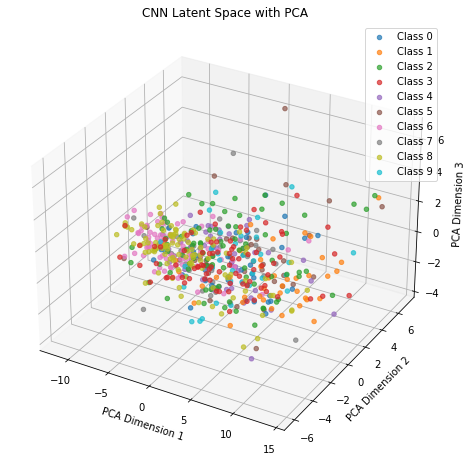

CNN latent space with PCA visualization completed.
Visualizing AST latent space with PCA...


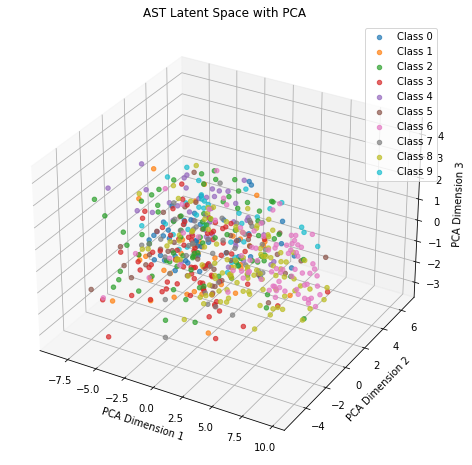

AST latent space with PCA visualization completed.
Visualizing RNN spectrograms latent space with PCA...


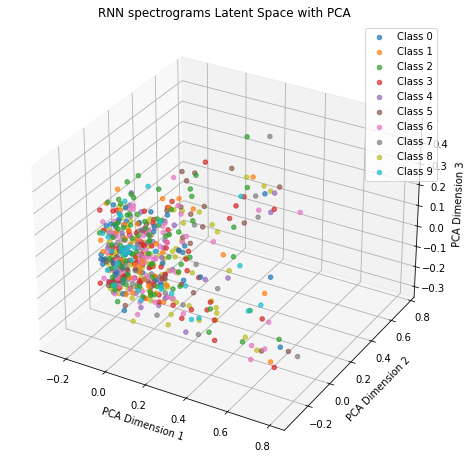

RNN spectrograms space with PCA visualization completed.
Visualizing RNN chromograms latent space with PCA...


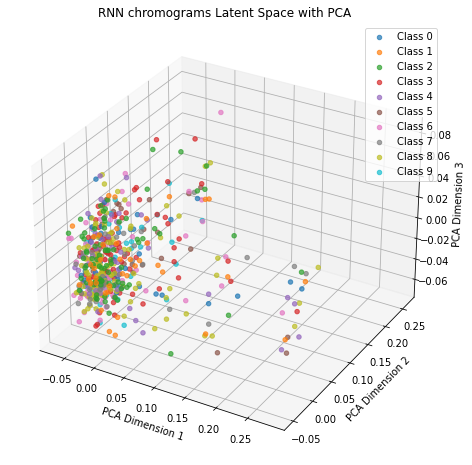

RNN chromograms space with PCA visualization completed.
Visualizing CNN latent space with t-SNE...


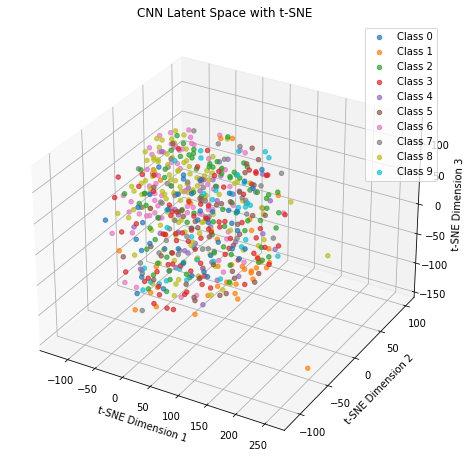

CNN latent space with t-SNE visualization completed.
Visualizing AST latent space with t-SNE...


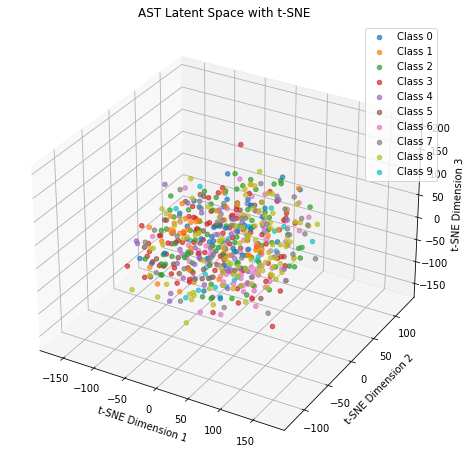

AST latent space with t-SNE visualization completed.
Visualizing RNN spectrograms latent space with t-SNE...


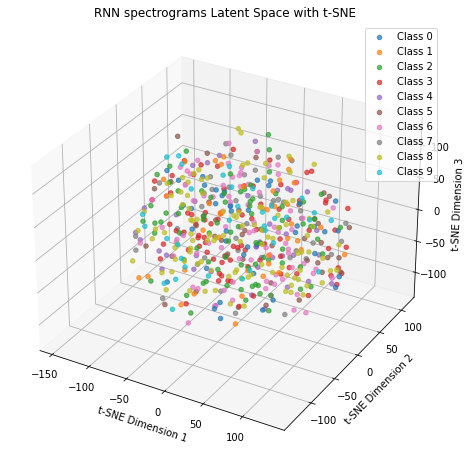

RNN spectrograms space with t-SNE visualization completed.
Visualizing RNN chromograms latent space with t-SNE...


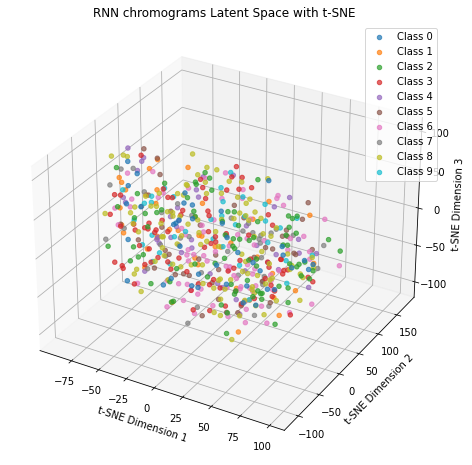

RNN chromograms space with t-SNE visualization completed.
Visualizing CNN latent space with UMAP...


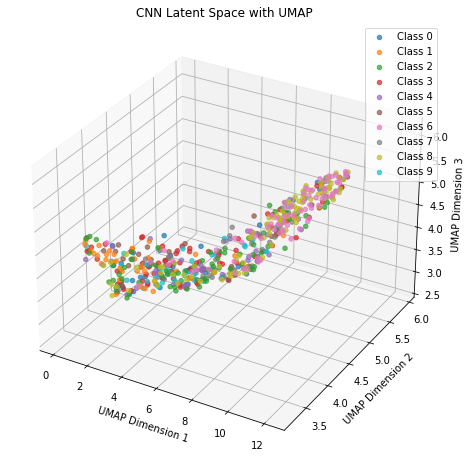

CNN latent space with UMAP visualization completed.
Visualizing AST latent space with UMAP...


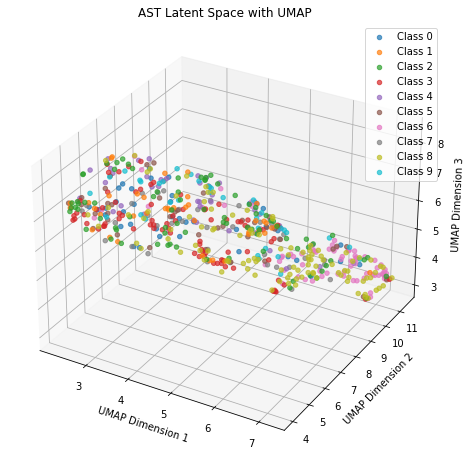

AST latent space with UMAP visualization completed.
Visualizing RNN spectrograms latent space with UMAP...


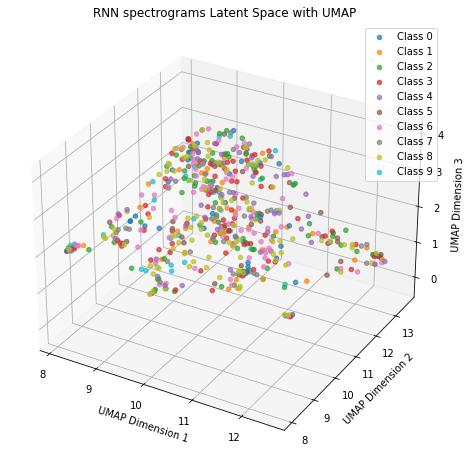

RNN spectrograms space with UMAP visualization completed.
Visualizing RNN chromograms latent space with UMAP...


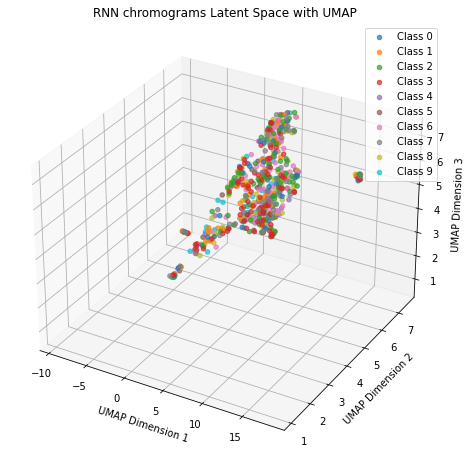

RNN chromograms space with UMAP visualization completed.


In [28]:
import os

# Create a directory for visualizations if it doesn't exist
output_dir = "visualizations"
os.makedirs(output_dir, exist_ok=True)

# Visualize PCA
print("Visualizing CNN latent space with PCA...")
visualize_latent_space_3d(cnn_latent_pca, cnn_labels, title="CNN Latent Space with PCA", algorithm="PCA", save_path=f"{output_dir}/cnn_latent_space_pca.png")
print("CNN latent space with PCA visualization completed.")

print("Visualizing AST latent space with PCA...")
visualize_latent_space_3d(ast_latent_pca, ast_labels, title="AST Latent Space with PCA", algorithm="PCA", save_path=f"{output_dir}/ast_latent_space_pca.png")
print("AST latent space with PCA visualization completed.")

print("Visualizing RNN spectrograms latent space with PCA...")
visualize_latent_space_3d(rnn_spec_latent_pca, rnn_spec_labels, title="RNN spectrograms Latent Space with PCA", algorithm="PCA", save_path=f"{output_dir}/rnn_spec_latent_space_pca.png")
print("RNN spectrograms space with PCA visualization completed.")

print("Visualizing RNN chromograms latent space with PCA...")
visualize_latent_space_3d(rnn_chrom_latent_pca, rnn_chrom_labels, title="RNN chromograms Latent Space with PCA", algorithm="PCA", save_path=f"{output_dir}/rnn_chrom_latent_space_pca.png")
print("RNN chromograms space with PCA visualization completed.")

# Visualize t-SNE
print("Visualizing CNN latent space with t-SNE...")
visualize_latent_space_3d(cnn_latent_tsne, cnn_labels, title="CNN Latent Space with t-SNE", algorithm="t-SNE", save_path=f"{output_dir}/cnn_latent_space_tsne.png")
print("CNN latent space with t-SNE visualization completed.")

print("Visualizing AST latent space with t-SNE...")
visualize_latent_space_3d(ast_latent_tsne, ast_labels, title="AST Latent Space with t-SNE", algorithm="t-SNE", save_path=f"{output_dir}/ast_latent_space_tsne.png")
print("AST latent space with t-SNE visualization completed.")

print("Visualizing RNN spectrograms latent space with t-SNE...")
visualize_latent_space_3d(rnn_spec_latent_tsne, rnn_spec_labels, title="RNN spectrograms Latent Space with t-SNE", algorithm="t-SNE", save_path=f"{output_dir}/rnn_spec_latent_space_tsne.png")
print("RNN spectrograms space with t-SNE visualization completed.")

print("Visualizing RNN chromograms latent space with t-SNE...")
visualize_latent_space_3d(rnn_chrom_latent_tsne, rnn_chrom_labels, title="RNN chromograms Latent Space with t-SNE", algorithm="t-SNE", save_path=f"{output_dir}/rnn_chrom_latent_space_tsne.png")
print("RNN chromograms space with t-SNE visualization completed.")

# Visualize UMAP
print("Visualizing CNN latent space with UMAP...")
visualize_latent_space_3d(cnn_latent_umap, cnn_labels, title="CNN Latent Space with UMAP", algorithm="UMAP", save_path=f"{output_dir}/cnn_latent_space_umap.png")
print("CNN latent space with UMAP visualization completed.")

print("Visualizing AST latent space with UMAP...")
visualize_latent_space_3d(ast_latent_umap, ast_labels, title="AST Latent Space with UMAP", algorithm="UMAP", save_path=f"{output_dir}/ast_latent_space_umap.png")
print("AST latent space with UMAP visualization completed.")

print("Visualizing RNN spectrograms latent space with UMAP...")
visualize_latent_space_3d(rnn_spec_latent_umap, rnn_spec_labels, title="RNN spectrograms Latent Space with UMAP", algorithm="UMAP", save_path=f"{output_dir}/rnn_spec_latent_space_umap.png")
print("RNN spectrograms space with UMAP visualization completed.")

print("Visualizing RNN chromograms latent space with UMAP...")
visualize_latent_space_3d(rnn_chrom_latent_umap, rnn_chrom_labels, title="RNN chromograms Latent Space with UMAP", algorithm="UMAP", save_path=f"{output_dir}/rnn_chrom_latent_space_umap.png")
print("RNN chromograms space with UMAP visualization completed.")
